# **Start**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title  { display-mode: "form" }
#@title  { display-mode: "form" }
#@title  { vertical-output: true, display-mode: "form" }
#@markdown Select The Best

use_pearson_corr = False #@param ["True", "False"]
Data_to_use = "6_bands" #@param ["6_bands", "65_bands", "372_bands", "Planet_hisar", "Pavia", "Indian_Pines", "Hisar_sentinel"]
use_pearson_corr = True if use_pearson_corr in [True, "True"] else False
P_S = "9"  #@param [3, 9, 15, 21]
patch_size = 3
P_S = int(P_S)
train_percent = 75  #@param [75, 80, 90]
GlobalFilter_layers = "5"  #@param [3,4,5,6,7,8,9,10,11,12]
# projection_dim = "512"    #@param [64, 128, 256, 512, 1024]
hidden_dim = "512"        #@param [64, 128, 256, 512, 1024]
mlp_ratio = 4             #@param [1,2,3,4]
dropout_rate = "0"        #@param [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
drop_path_rate = "0"        #@param [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

Targeted_accuracy = "0.985" #@param [0.97, 0.98, 0.985, 0.99, 0.995]
Min_trainable_epoch = 20 #@param [20, 25, 30, 35, 40, 50, 100]

train_percent = 75                  #@param [75, 80, 90]
epoch = 100                         #@param [100, 200, 300, 400, 500]

LR_START = 3e-3
LR_MAX = 6e-3
LR_MIN = 1e-5

batch_size = 128
BATCH_SIZE = 128
dropout_rate = "0.25"                 #@param [0.1, 0.2, 0.25, 0.3, 0.4, 0.5]

P_S = int(P_S)
epoch = int(epoch)
train_percent = int(train_percent)
num_patches = (P_S//patch_size)**2

GlobalFilter_layers = int(GlobalFilter_layers)
hidden_dim = int(hidden_dim)
mlp_ratio = int(mlp_ratio)
dropout_rate = float(dropout_rate)
drop_path_rate = float(drop_path_rate)

Min_trainable_epoch = int(Min_trainable_epoch)
Targeted_accuracy = float(Targeted_accuracy)
train_percent = int(train_percent)
dropout_rate = float(dropout_rate)
shifts = int(1/dropout_rate)
assert epoch >= Min_trainable_epoch/dropout_rate, f"For Min_trainable_epoch: {Min_trainable_epoch} & dropout_rate: {dropout_rate}, minimum number of `epoch` should be {Min_trainable_epoch/dropout_rate}"
print("Number of patches per P_S: ", num_patches)
print("Size of each patch for Multihead Attention: ", patch_size)

Number of patches per P_S:  9
Size of each patch for Multihead Attention:  3


In [ ]:
!pip install spectral
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 8.8 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow_addons (from versions: none)
ERROR: No matching distribution found for tensorflow_addons


In [ ]:
import pandas as pd           # for csv files and dataframes
import numpy as np            # Linear Algebra tools
import matplotlib.pyplot as plt  # for ploting graphs and curve
from matplotlib import colors, cm, gridspec
import scipy.stats as st
import scipy.io as si         # for inputing matlab files
from random import shuffle    # for shuffling dataset
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix   #Confusion matrix creation
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report

import datetime
import time
import warnings
import math
import os
import gc

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.python.util.tf_export import keras_export
from tensorflow.keras import Sequential, layers, activations
from tensorflow.keras.layers import Input, Add, Multiply, Reshape, Dense, Activation, BatchNormalization, Flatten, Dropout, concatenate, Lambda
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D,  GlobalAveragePooling2D, GlobalAvgPool2D, DepthwiseConv2D, SeparableConv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, add, multiply, LayerNormalization
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.utils import control_flow_util
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import glorot_uniform, Ones
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.regularizers import l2

import spectral

np.random.seed(1337)          # to get reproducible results
base_path = "/content/drive/MyDrive/m_p/Uncertainty in Models/Global Filter Networks/"

try:
    os.mkdir(base_path)
except:
    pass

try:
    os.mkdir(base_path + "With Pearson correlation/") if use_pearson_corr else os.mkdir(base_path + "Without Pearson correlation/")
except:
    pass

if use_pearson_corr:
    folder_path = base_path + "With Pearson correlation/" + str(Data_to_use) + "/"
    try:
        os.mkdir(folder_path)
    except:
        pass
else:
    folder_path = base_path + "Without Pearson correlation/" + str(Data_to_use) + "/"
    try:
        os.mkdir(folder_path)
    except:
        pass

In [ ]:
try:
    os.mkdir(folder_path + "Trained models")
    os.mkdir(folder_path + "Results")
except:
    pass

In [ ]:
Normalize_data = True
if Data_to_use == "6_bands":
    H, W, B = 330, 307, 6
    x = np.array(pd.read_csv('/content/drive/My Drive/m_p/data/multispectral/data.csv'))
    y = np.array(pd.read_csv('/content/drive/My Drive/m_p/data/multispectral/ref.csv'))

if Data_to_use == "65_bands":
    H, W, B = 512, 512, 65
    x = si.loadmat('/content/drive/My Drive/m_p/data/Dias/DIAS.mat')['DIAS']
    y = si.loadmat('/content/drive/My Drive/m_p/data/Dias/DIAS_ref.mat')['DIAS_ref']

if Data_to_use == "372_bands":
    H, W, B = 1101, 566, 372
    x = si.loadmat('/content/drive/My Drive/m_p/data/372 band/full.mat')['full']
    y = si.loadmat('/content/drive/My Drive/m_p/data/372 band/full_gt.mat')['full_gt']
    x[x < 0.0] = 0.0
    x[x > 1.0] = 1.0
    Normalize_data = False
    #x = x[:, selective_bands]

if Data_to_use == "Planet_hisar":
    H, W, B = 1733, 2647, 4
    x = pd.read_csv('/content/drive/My Drive/m_p/data/planet_data_hisar/planet.csv', header=None)
    y = pd.read_csv('/content/drive/My Drive/m_p/data/planet_data_hisar/planetgt.csv', header=None)

if Data_to_use == "Pavia":
    H, W, B = 610, 340, 103
    x = si.loadmat('/content/drive/MyDrive/m_p/data/pavia/paviauni.mat')['paviaU']
    y = si.loadmat('/content/drive/MyDrive/m_p/data/pavia/paviauni_gt.mat')['paviaU_gt']

if Data_to_use == "Indian_Pines":
    H, W, B = 145, 145, 220
    x = si.loadmat('/content/drive/My Drive/m_p/data/Indian_pines/Indian_pines.mat')['indian_pines']
    y = si.loadmat('/content/drive/My Drive/m_p/data/Indian_pines/Indian_pines_gt.mat')['indian_pines_gt']

if Data_to_use == "Hisar_sentinel":
    H, W, B = 722, 1014, 4
    x = np.array(si.loadmat('/content/drive/My Drive/m_p/data/Hissar_25%/datas.mat')['datas'])
    y = np.array(pd.read_csv('/content/drive/My Drive/m_p/data/Hissar_25%/fullgt.csv'))

y_shape = np.array(y).shape[0]
x, y = np.array(x).reshape(H,W,B), np.array(y).reshape(H,W)
x = x.astype('float16')
#########
print("minimum value in raw data is :", x.min())
print("maximum value in raw data is :", x.max(), "\n")
print("shape of raw data: ", x.shape)
print("shape of target data: ", y.shape, "\n")

# Normalizing the data between 0,1
if Normalize_data:
    for i in range(B):
        band_min = x[:,:,i].min()
        band_max = x[:,:,i].max()
        band_range = band_max - band_min
        x[:,:,i] = (x[:,:,i] - band_min)/band_range

minimum value in raw data is : 12.0
maximum value in raw data is : 209.0 

shape of raw data:  (330, 307, 6)
shape of target data:  (330, 307) 



In [ ]:
pad_width = int((P_S-1)/2)
padded_x = np.pad(x,[(pad_width,pad_width),(pad_width,pad_width),(0,0)],'edge')
# np.save("/content/drive/MyDrive/Personal Folder for training/padded_x.npy" , padded_x)
X,Y = [],[]
for a in range(H):
  for b in range(W):
    if(y[a][b]!= 0):
      patch = padded_x[a:a+P_S,b:b+P_S,:]
      X.append(patch)
      Y.append(y[a][b]-1)

num_classes = len(np.unique(y))-1
Approximate_rgb_img = x[:,:,[B//2-1, B//2, B//2+1]]*255

print()
print("minimum value in x is :", x.min())
print("maximum value in x is :", x.max())
print()
print("shape of x: ", x.shape)
print("shape of y: ", y.shape)
print()
print("shape of padded_x: ", padded_x.shape, "\n")
print(f"{len(Y)*100/y_shape:.4f}% of data is labeled with {num_classes} classes")


minimum value in x is : 0.0
maximum value in x is : 1.0

shape of x:  (330, 307, 6)
shape of y:  (330, 307)

shape of padded_x:  (338, 315, 6) 

17.0161% of data is labeled with 7 classes


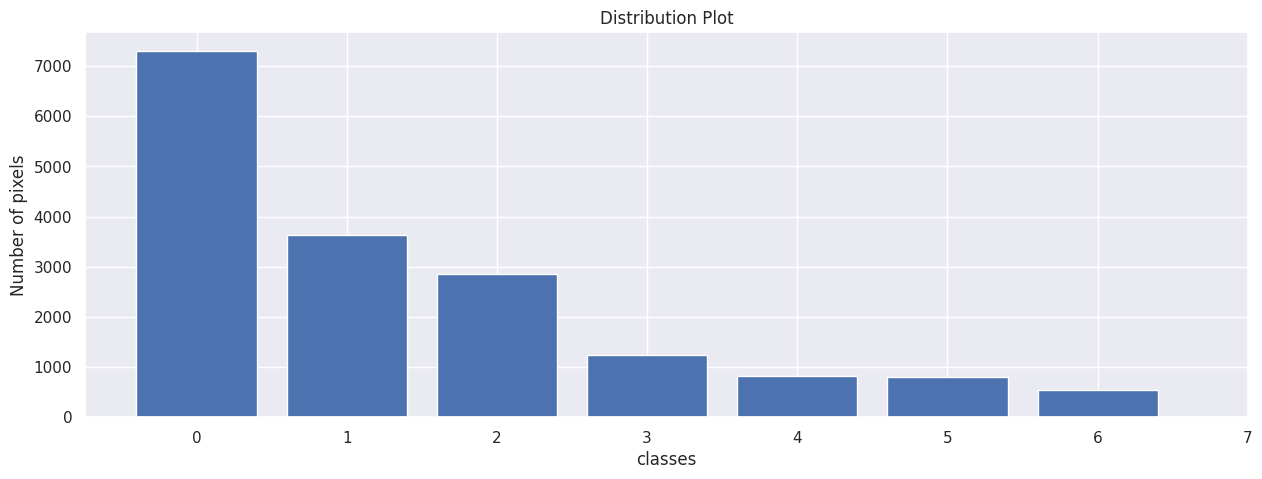

In [ ]:
class_labels, value_counts = np.unique(y.reshape(-1,1), return_counts = True)
plt.figure(figsize = (15,5))
plt.bar(class_labels[1:]-1, value_counts[1:])
plt.xticks(class_labels, rotation = 0)
plt.xlabel("classes")
plt.ylabel("Number of pixels")
plt.title("Distribution Plot")
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=(train_percent/100),stratify=Y, random_state=10)
x_train,x_test,y_train,y_test = np.array(x_train),np.array(x_test),np.array(y_train),np.array(y_test)
print(f"x_train: {x_train.shape} \nx_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}")

x_train: (12929, 9, 9, 6) 
x_test: (4310, 9, 9, 6) 
y_train: (12929,) 
y_test: (4310,)


# **Functions**

In [ ]:
def predict_half_image(model, padded_x, H, W_range, B, P_S, num_classes):
    y_hat = np.zeros((H,W_range))
    y_prob = np.zeros((H, W_range, num_classes))
    for j in range(W_range):
        patchs = np.zeros((H, P_S, P_S, B))
        for i in range(H):
            patchs[i,:,:,:] = padded_x[i:i+P_S, j:j+P_S, :]
        prob = model.predict(patchs, verbose = -1)
        # y_pred = np.argmax(prob,axis=1)+1
        y_prob[:,j,:] = prob
        y_hat[:,j] = np.argmax(prob,axis=1)+1
        del patchs, prob
        gc.collect()
    return y_hat, y_prob


def predict_image(model, padded_x, H, W, B, P_S, num_classes):
    start_time = time.time()
    half_1 = padded_x.shape[1]//2 + pad_width+1
    half_2 = padded_x.shape[1]//2 - pad_width-1
    padded_x_1st_half = padded_x[:,:half_1, :]
    padded_x_2nd_half = padded_x[:,half_2:, :]
    del padded_x
    gc.collect()

    y_hat = np.zeros((H,W))
    y_prob = np.zeros((H,W, num_classes))
    y_hat[:,:W//2], y_prob[:,:W//2,:] = predict_half_image(model, padded_x_1st_half, H, W//2, B, P_S, num_classes)
    # del padded_x_1st_half
    print("image predicted ███████████████████████ 50%")
    gc.collect()
    width = W//2 if W//2 == W/2 else W//2+1
    y_hat[:,W//2:], y_prob[:,W//2:,:] = predict_half_image(model, padded_x_2nd_half, H, width, B, P_S, num_classes)
    # del padded_x_2nd_half
    print("image predicted ██████████████████████████████████████████████ 100%")
    gc.collect()
    end_time = time.time()
    time_taken = end_time - start_time
    time_min = time_taken//60
    time_sec = time_taken - time_min*60
    print(f'total time taken is: {time_min} min {time_sec:.2f} sec.')
    y_hat = np.reshape(y_hat, (H,W))
    y_prob = np.reshape(y_prob, (H, W, num_classes))
    print("shape of predicted image is: ", y_hat.shape)
    return y_hat, y_prob

In [ ]:
def predict_half_image_prob(model, padded_x, H, W_range, B, P_S):
    y_prob = np.zeros((H, W_range, num_classes))
    for j in range(W_range):
        patchs = np.zeros((H, P_S, P_S, B))
        for i in range(H):
            patchs[i,:,:,:] = padded_x[i:i+P_S, j:j+P_S, :]
        y_pred_prob = model.predict(patchs, verbose = -1)
        y_prob[:,j,:] = y_pred_prob
        del patchs, y_pred_prob
        gc.collect()
    return y_prob

def probabilistic_outputs(model, padded_x, H, W, B, P_S):
    start_time = time.time()
    half_1 = padded_x.shape[1]//2 + pad_width+1
    half_2 = padded_x.shape[1]//2 - pad_width-1
    padded_x_1st_half = padded_x[:,:half_1, :]
    padded_x_2nd_half = padded_x[:,half_2:, :]
    del padded_x
    gc.collect()

    y_hat = np.zeros((H,W, num_classes))
    y_hat[:,:W//2,:] = predict_half_image_prob(model, padded_x_1st_half, H, W//2, B, P_S)
    print("image predicted ███████████████████████ 50%")
    gc.collect()
    width = W//2 if W//2 == W/2 else W//2+1
    y_hat[:,W//2:,:] = predict_half_image_prob(model, padded_x_2nd_half, H, width, B, P_S)
    print("image predicted ██████████████████████████████████████████████ 100%")
    gc.collect()
    end_time = time.time()
    time_taken = end_time - start_time
    time_min = time_taken//60
    time_sec = time_taken - time_min*60
    print(f'total time taken is: {time_min} min {time_sec:.2f} sec.')
    print("shape of predicted image is: ", y_hat.shape)
    return y_hat

In [ ]:
def predict(model, x_test):
    y_pred = np.argmax(model.predict(x_test, verbose = -1), axis = -1)
    return y_pred

In [ ]:
def plot_accuracy_loss_curve(history, use_pearson_corr = None, folder_path = None):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize = (24,8))
    ax = plt.subplot(1,1,1)
    ax2 = ax.twinx()
    ax.plot(train_accuracy, color='blue', marker='o', linewidth=1.5, markersize = 2,  label = 'train_accuracy')
    ax.plot(val_accuracy, color='green', marker='o', linewidth=1.5, markersize = 2, label = 'val_accuracy')
    ax.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('accuracy')
    ax.legend()
    ax2.plot(train_loss, color = 'black', marker='o', linewidth=1.5, markersize = 2, label = 'train_loss')
    ax2.plot(val_loss, color = 'red', marker='o', linewidth=1.5, markersize = 2, label = 'val_loss')
    ax2.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('loss')
    plt.title('accuracy and loss plot for model performance')
    ax2.legend()
    plt.show()
    if folder_path:
        if use_pearson_corr:
            path = folder_path + "Results/Pearson_Corr " + str(train_percent) + "% ps_"+ str(P_S) + " accuracy_loss.png"
        else:
            path = folder_path + "Results/" + str(train_percent) + "% ps_"+ str(P_S) + " accuracy_loss.png"
        fig.savefig(path)

In [ ]:
def performance_meausures(y_test, y_pred, tt, *parameters_summary, folder_path = None):
    Total_params, Trainable_params, Non_trainable_params = parameters_summary
    accuracy = accuracy_score(y_test, y_pred)
    kappa=cohen_kappa_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred).astype('int32')
    cr = classification_report(y_test, y_pred, output_dict=True)
    df_cr = pd.DataFrame(cr).T
    df_score = pd.DataFrame({'accuracy score: ' : [accuracy], 'Cohen_Kappa score: ' : [kappa], "Training Time: " : [tt]}).T
    df_summary = pd.DataFrame({'Total_params: ': [Total_params], 'Trainable_params: ' : [Trainable_params], 'Non_trainable_params: ':[Non_trainable_params]}).T

    spec = gridspec.GridSpec(ncols = 2, nrows = 2, width_ratios=[1,3], wspace = 0.5, hspace = 0.5, height_ratios=[7,1])

    fig = plt.figure(figsize = (24,10))

    ax1 = fig.add_subplot(spec[0])
    ax1.set_title('classification report')
    sns.heatmap(df_cr, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax1)

    ax2 = fig.add_subplot(spec[1])
    ax2.set_title('confusion matrix')
    ax2.set_xlabel('predicted class')
    ax2.set_ylabel('actual class')
    sns.heatmap(cm, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax2)

    ax3 = fig.add_subplot(spec[2])
    sns.heatmap(df_score, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax3)
    ax3.set_xticks([])

    ax4 = fig.add_subplot(spec[3])
    sns.heatmap(df_summary, cmap = "Blues", cbar = False, annot = True, fmt=' .10g', ax = ax4)
    ax4.set_xticks([])

    if folder_path:
        path = folder_path + "Results/" + str(train_percent) + "% ps_" + str(P_S) +" Performance Measure.png"
        fig.savefig(path)

In [ ]:
def measure_uncertainty(model, x_test, y_test):
    y_prob = model.predict(x_test, verbose = -1)

    """Sorting is as follow
    y_prob = [[11 12 13 22]
              [31 10 33  7]
              [21  7 23 14]]

    temp_prob will sort the y_prob along rows
    temp_prob = [[11 12 13 22]
                 [7  10 31 33]
                 [7  14 21 23]]

    Now sort the y_prob based on the last column of temp_pred i.e. last col is [22, 33, 23] and sorting will be [22, 23, 33] ---> [0, 2, 1]
     y_prob = [[11 12 13 22]
               [21  7 23 14]
               [31 10 33  7]]
    """
    temp_pred = np.sort(y_prob, axis = -1)      # sort the probabilities along rows. Higher prob values are along last column
    y_prob = y_prob[temp_pred[:,-1].argsort()]  # Arange the rows of predicted prob in assending position

    num = y_prob.shape[0]
    # observed = y_prob.max(axis = -1)
    observed = np.sort(y_prob, axis = -1)[:,-1]    # class predicted according to 1st maximum prob
    observed_1 = np.sort(y_prob, axis = -1)[:,-2]  # class predicted according to 2nd maximum prob
    observed_2 = np.sort(y_prob, axis = -1)[:,-3]  # class predicted according to 3rd maximum prob

    mean = y_prob.mean(axis = -1)
    std = y_prob.std(axis = -1)
    plt.figure(figsize = (24,8))
    plt.plot(np.arange(1, num+1, 1), observed - observed_1, color = "black", label = "certaintity")
    plt.plot(np.arange(1, num+1, 1), observed, color = "blue", label = "observed")
    plt.plot(np.arange(1, num+1, 1), observed_1, color = "purple", label = "observed_1")
    plt.plot(np.arange(1, num+1, 1), observed_2, color = "cyan", label = "observed_2")
    plt.plot(np.arange(1, num+1, 1), mean, color = "red", label = "mean")
    plt.plot(np.arange(1, num+1, 1), mean + 2*std, color = "green", label = "mean + 2*std")
    plt.plot(np.arange(1, num+1, 1), mean - 2*std, color = "green", label = "mean - 2*std")
    plt.legend()
    plt.title("Predictions based on normal model")
    plt.show()

In [ ]:
class Pearson_correlation_masked(layers.Layer):
    def __init__(self, P_S = 9, **kwargs):
        super(Pearson_correlation_masked, self).__init__(**kwargs)
        self.P_S = P_S

    def call(self, inputs):
        self.loc = (self.P_S)//2
        self.inputs = inputs
        self.channels = self.inputs.shape[-1]
        self.x_mean = tf.repeat(tf.math.reduce_mean(self.inputs, axis = -1, keepdims=True), repeats = self.channels, axis = -1)

        self.y = tf.repeat(tf.repeat(self.inputs[:,self.loc:self.loc+1, self.loc:self.loc+1, :], repeats = self.P_S, axis = -2), repeats = self.P_S, axis = -3)

        self.y_mean = tf.repeat(tf.math.reduce_mean(self.y, axis = -1, keepdims = True), repeats = self.channels, axis = -1)

        self.a = tf.math.subtract(self.inputs, self.x_mean)
        self.b = tf.math.subtract(self.y, self.y_mean)
        self.ab = tf.math.multiply(self.a,self.b)
        self.num = tf.math.reduce_sum(self.ab, axis = -1, keepdims = True)

        self.a_new = tf.math.reduce_sum(tf.math.multiply(self.a, self.a), axis = -1, keepdims = True)
        self.b_new = tf.math.reduce_sum(tf.math.multiply(self.b, self.b), axis = -1, keepdims = True)
        self.deno = tf.math.sqrt(tf.math.multiply(self.a_new, self.b_new))

        self.corr = tf.math.divide(self.num, self.deno)

        self.thresh = tf.math.reduce_mean(self.corr)
        self.mask = self.corr > self.thresh
        self.mask = tf.cast(self.mask, self.corr.dtype)

        self.masked_corr = tf.math.multiply(self.mask, self.corr)

        self.attention_weights = tf.repeat(self.masked_corr, repeats = self.channels, axis = -1)
        return multiply([self.inputs, self.attention_weights])

    def get_config(self, **kwargs):
        config = super(Pearson_correlation_masked, self).get_config()
        config.update({
            "P_S": self.P_S,
        })
        return config

In [ ]:
@keras_export('keras.layers.Dropout')
class Dropout_Train(layers.Layer):
    def __init__(self, rate, shift = 1, noise_shape=None, seed=None, **kwargs):
        super(Dropout_Train, self).__init__(**kwargs)

        if isinstance(rate, (int, float)) and not 0 <= rate <= 1:
            raise ValueError(f"Invalid value {rate} received for `rate`, expected a value between 0 and 1.")
        if type(shift) != int:
            raise TypeError(f"Invalid dtype {type(shift)} found for `shift`. It must be an integer")
        if shift*rate > 1.0:
            raise ValueError(f"Invalid value {shift} received for `shift`, expected an integer value less than or equal to {int(1/rate)}")
        self.rate = rate
        self.shift = shift
        self.noise_shape = noise_shape
        self.seed = seed
        self.supports_masking = True

    def _get_noise_shape(self, inputs):
        if self.noise_shape is None:
            return None

        concrete_inputs_shape = array_ops.shape(inputs)
        noise_shape = []
        for i, value in enumerate(self.noise_shape):
            noise_shape.append(concrete_inputs_shape[i] if value is None else value)
        return tf.convert_to_tensor(noise_shape)

    def call(self, inputs, training=None):
        if self.rate == 0:
            return tf.identity(inputs)

        if training is None:
            training = K.learning_phase()

        def dropped_inputs():
            input_shape = inputs.shape
            range_0 = int(self.rate*(self.shift-1)*input_shape[-1])
            if self.shift*self.rate < 1.0:
                range_1 = int(self.rate*(self.shift)*input_shape[-1])
            else:
                range_1 = None
            input_shape = inputs.shape
            multiplier = np.ones(input_shape[-1])
            multiplier[range_0:range_1] = 0.0
            multiplier = tf.constant(multiplier)
            return Multiply()([inputs, multiplier])

        output = control_flow_util.smart_cond(training, dropped_inputs, lambda: array_ops.identity(inputs))
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super(Dropout_Train, self).get_config()
        config.update({
            "rate": self.rate,
            "shift": self.shift,
            "noise_shape": self.noise_shape,
            "seed": self.seed,
            "supports_masking": self.supports_masking
        })
        return config

In [ ]:
def modified_model(model, layer_name, rate, new_layer, shift, **kwargs):    # layer_name = "TRAIN_DROPOUT"
    name = kwargs["name"] if kwargs else None
    x = model.layers[0].output
    modification = False
    z = 0
    for lyr in model.layers[1:]:
        if (layer_name in lyr.name or layer_name in lyr.name.upper()) and (type(shift) != str):
            x = new_layer(rate = rate, shift = shift, name = layer_name + "_" + str(shift) + "_" + str(z))(x)
            modification = True
            z += 1
        elif (layer_name in lyr.name or layer_name in lyr.name.upper()) and (type(shift) == str):
            x = new_layer(rate = rate, name = layer_name + "_" + str(shift) + "_" + str(z))(x)
            z += 1
            modification = True
        else:
            x = lyr(x)
    if not modification:
        print("___________________________________Model has not been modified___________________________________")
    return Model(inputs = model.layers[0].input, outputs = x, name = name)

In [ ]:
class Custom_callbacks(tf.keras.callbacks.Callback):
    def __init__(self, filepath, epochs, rate, new_layer = Dropout_Train, layer_name = "DROPOUT", accuracy_score = 0.99, min_epochs = 50):
        super(Custom_callbacks, self).__init__()
        self.filepath = filepath
        self.epochs = epochs
        self.new_layer = new_layer
        self.rate = rate
        self.best = 0.0
        self.epoch_num = 1
        self.layer_name = layer_name
        self.min_epochs = min_epochs                    # minimum number of epochs that model should be trained in each shift
        self.accuracy_score = accuracy_score if accuracy_score <= 1.0 else accuracy_score/100.0

    def on_train_begin(self, logs=None):
        print(self.epochs)
        keys = list(logs.keys())
        self.shift = 1
        self.epoch_completed = 0
        print(f"Model will be trained in {int(1/self.rate)} shifts")
        print("Starting training with 1st shift \n")
        self.model = modified_model(self.model, self.layer_name, self.rate, self.new_layer, self.shift)

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        if self.shift <= int(1/self.rate):
            raise NotImplementedError(f"model has not trained fully in the available no. of epochs \n only {self.shift-1} shifts completed out of {int(1/self.rate)}")
        print("Model training completition ", "███████████"*self.shift, (self.rate*(self.shift-1))*100, "%")
        print(f"Model has been fully trained in {int(1/self.rate)} shifts")
        self.model.set_weights(self.best_weights)
        print(f"\nSaving best model to {self.filepath}")
        self.model.save(self.filepath)

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        self.epoch_completed += 1
        self.epoch_num += 1

        if (logs["val_accuracy"] >= self.accuracy_score) and (self.epoch_completed >= self.min_epochs) and (self.shift < int(1/self.rate)):
            print("\nTargeted accuracy has been achieved")
            print("Model training completition ", "███████████"*(self.shift), (self.rate*self.shift)*100, "%")
            self.shift += 1
            Suffixes = "nd" if (self.shift == 2) else "th"
            print(f"Modifying the model for {self.shift}{str(Suffixes)} shift")
            self.model = modified_model(self.model, self.layer_name, self.rate, self.new_layer, self.shift)
            self.epoch_completed = 0

        elif (logs["val_accuracy"] >= self.accuracy_score) and (self.epoch_completed >= self.min_epochs) and (self.shift == int(1/self.rate)):
            print("\nModel training completition ", "███████████"*(self.shift), (self.rate*self.shift)*100, "%")
            print("All shifting has been completed\n")
            print("██████████████████████===============> Now redefining the model to standard model <===============██████████████████████")
            self.model = modified_model(self.model, self.layer_name, self.rate, self.new_layer, "Final", name = "GFNet")
            self.shift += 1
            self.epoch_completed = 0

        else:
            print(", need more training")
            if self.shift >= int(1/self.rate):
                current = logs.get("val_accuracy")
                if not np.less(current, self.best) and (self.epoch_num >= self.epochs-10):
                    print(f"val_accuracy improved from {self.best:.4f} to {current:.4f}")
                    self.best = current
                    self.best_weights = self.model.get_weights()

    def get_config(self):
        config = super(Custom_callbacks, self).get_config()
        config.update({
            "filepath": self.filepath,
            "epochs": self.epochs,
            "new_layer": self.new_layer,
            "rate": self.rate,
            "best": self.best,
            "epoch_num": self.epoch_num,
            "layer_name": self.layer_name,
            "min_epochs": self.min_epochs,
            "accuracy_score": self.accuracy_score,
        })
        return config

In [ ]:
class MLP(layers.Layer):
    def __init__(self, in_features, out_features, drop = 0.0, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.drop = drop
        self.mlp_1 = Dense(in_features, activation = activations.gelu, use_bias = False)
        self.drop_1 = Dropout(drop)
        self.mlp_2 = Dense(out_features, activation = activations.gelu, use_bias = False)
        self.drop_2 = Dropout(drop)

    def call(self, x):
        x = self.drop_1(self.mlp_1(x))
        x = self.drop_2(self.mlp_2(x))
        return x

    def get_config(self, **kwargs):
        config = super(MLP, self).get_config()
        config.update({
            "in_features": self.in_features,
            "out_features": self.out_features,
            "drop": self.drop,
        })
        return config

class DropPath(layers.Layer):
    def __init__(self, drop_prob = 0.0, training = False, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob
        self.training = training
    def call(self, x, **kwargs):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 -  self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + tf.random.uniform(shape, dtype=x.dtype)
        random_tensor.floor_()  # binarize
        output = tf.divide(x, keep_prob) * random_tensor
        return output
    def get_config(self, **kwargs):
        config = super(DropPath, self).get_config()
        config.update({
            "drop_prob": self.drop_prob,
            "training": self.training,
        })
        return config

In [ ]:
class Expand_Dims(layers.Layer):
    def __init__(self, ndim, **kwargs):
        super(Expand_Dims, self).__init__(**kwargs)
        self.ndim = ndim

    def call(self, x):
        x = tf.expand_dims(x, axis = self.ndim)
        return x

    def config(self, **kwargs):
        config = super(Expand_Dims, self).config()
        config.update({
            "ndim" : self.ndim,
        })
        return config

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size = 3, hidden_dim = 256, patch_method='extract', **kwargs):
        super(Patches, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim
        self.patch_method = patch_method.lower()

    def call(self, images):
        if self.patch_method == "conv":
            x = Conv2D(self.hidden_dim, self.patch_size, self.patch_size)(images)              # shape(B, 3, 3, 256)
            patches = Reshape([-1, x.shape[-1]])(x)                                   # shape(B, 9, 256)
            return patches
        else:
            batch_size = tf.shape(images)[0]
            patches = tf.image.extract_patches(images=images, sizes=[1, self.patch_size, self.patch_size, 1], strides=[1, self.patch_size, self.patch_size, 1],
                                            rates=[1, 1, 1, 1], padding="VALID",)
            patch_dims = patches.shape[-1]
            patches = tf.reshape(patches, [batch_size, -1, patch_dims])
            return patches
    def get_config(self):
        config = super(Patches, self).get_config()
        config.update({
            "patch_size": self.patch_size,
            "hidden_dim": self.hidden_dim,
            "patch_method": self.patch_method
        })
        return config

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch,**kwargs):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self, **kwargs):
        config = super(PatchEncoder, self).get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection_dim,
        })
        return config

In [ ]:
class GlobalFilter(layers.Layer):
    def __init__(self, patch_size, dim, **kwargs):
        super(GlobalFilter, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.dim = dim

    def build(self, input_shape):
        w_init = tf.random_uniform_initializer()
        self.complex_weight = self.add_weight(
            name="complex_weight",
            shape=(self.patch_size, self.patch_size, input_shape[-1] // 2 + 1, 2),
            initializer=w_init,
            trainable=True
        )
        super().build(input_shape)

    def call(self, x, **kwargs):
        B, N, C = x.shape
        a = b = int(math.sqrt(N))
        x = tf.reshape(x, [-1, a, b, C])
        x = tf.signal.rfft2d(x)
        weight = tf.dtypes.complex(self.complex_weight[:,:,:,0], self.complex_weight[:,:,:,-1])
        x = x * weight
        x = tf.signal.irfft2d(x)
        x = tf.reshape(x, [-1, N, C])
        return x

    def config(self, **kwargs):
        config = super(GlobalFilter, self).config()
        config.update({
            "patch_size" : self.patch_size,
            "dim" : self.patch_size,
        })
        return config

In [ ]:
class Block(tf.keras.layers.Layer):
    def __init__(self, patch_size=3, dim=512, mlp_ratio=4.0, drop=0.0, drop_path=0.0, **kwargs):
        super(Block, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.dim = dim
        self.mlp_ratio = mlp_ratio
        self.drop = drop
        self.drop_path_rate = drop_path

        # Define sublayers
        self.norm1 = tf.keras.layers.LayerNormalization(axis=-1)
        self.filter = GlobalFilter(patch_size, dim)  # Make sure GlobalFilter uses add_weight inside its build()
        self.drop_path = DropPath(drop_path)
        self.norm2 = tf.keras.layers.LayerNormalization(axis=-1)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=mlp_hidden_dim, out_features=dim, drop=drop)

    def call(self, x):
        # Transformer-like residual block
        x = x + self.drop_path(self.mlp(self.norm2(self.filter(self.norm1(x)))))
        return x

    def get_config(self):
        config = super(Block, self).get_config()
        config.update({
            "patch_size": self.patch_size,
            "dim": self.dim,
            "mlp_ratio": self.mlp_ratio,
            "drop": self.drop,
            "drop_path": self.drop_path_rate,
        })
        return config

In [ ]:
def  GFNet(input_shape=(P_S,P_S,B),use_pearson_corr = False,patch_size=3,num_classes=16,hidden_dim=512,GlobalFilter_layers=12,mlp_ratio=4,num_patches=9,dropout_rate=0.0,drop_path_rate=0.0):
    input = Input(shape=input_shape)
    if use_pearson_corr:
        x = Pearson_correlation_masked(P_S)(input)
    else:
        x = input
    x = Patches(patch_size)(x)                                      # shape = 9, 3348 ----> 9 patches each shape 3*3*372 = 3348
    x = PatchEncoder(num_patches, hidden_dim)(x)                # shape = 9, 2048
    x = Dropout(dropout_rate, name = "TRAIN_DROPOUT_1")(x)
    for _ in range(GlobalFilter_layers):
        x = Block(patch_size = patch_size, dim = hidden_dim, mlp_ratio=mlp_ratio, drop=dropout_rate, drop_path=drop_path_rate)(x)

    x = Dropout(dropout_rate, name = "TRAIN_DROPOUT_2")(x)
    x = LayerNormalization()(x)
    # x = tf.expand_dims(x, axis = -2)
    x = Expand_Dims(ndim = 2)(x)
    x = GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = Dropout(dropout_rate, name = "TRAIN_DROPOUT_3")(x)
    x_output = Dense(num_classes, activation = "softmax")(x)
    model = keras.Model(inputs = input, outputs = x_output, name = "GFNet")
    return model

In [ ]:
model = GFNet((P_S, P_S, B),use_pearson_corr, patch_size, num_classes, hidden_dim, GlobalFilter_layers, mlp_ratio, num_patches, dropout_rate, drop_path_rate)

In [ ]:
model.summary()

Model: "GFNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9, 9, 6)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patches (Patches)               │ (None, None, 54)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_encoder (PatchEncoder)    │ (None, 9, 512)         │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TRAIN_DROPOUT_1 (Dropout)       │ (None, 9, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block (Block)                   │ (None, 9, 512)         │     2,103,826 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_1 (Block)                 │ (None, 9, 512)         │     2,103,826 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_2 (Block)                 │ (None, 9, 512)         │     2,103,826 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_3 (Block)                 │ (None, 9, 512)         │     2,103,826 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_4 (Block)                 │ (None, 9, 512)         │     2,103,826 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TRAIN_DROPOUT_2 (Dropout)       │ (None, 9, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_10          │ (None, 9, 512)         │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand__dims (Expand_Dims)      │ (None, 9, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TRAIN_DROPOUT_3 (Dropout)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,556,513 (40.27 MB)

 Trainable params: 10,556,513 (40.27 MB)

 Non-trainable params: 0 (0.00 B)

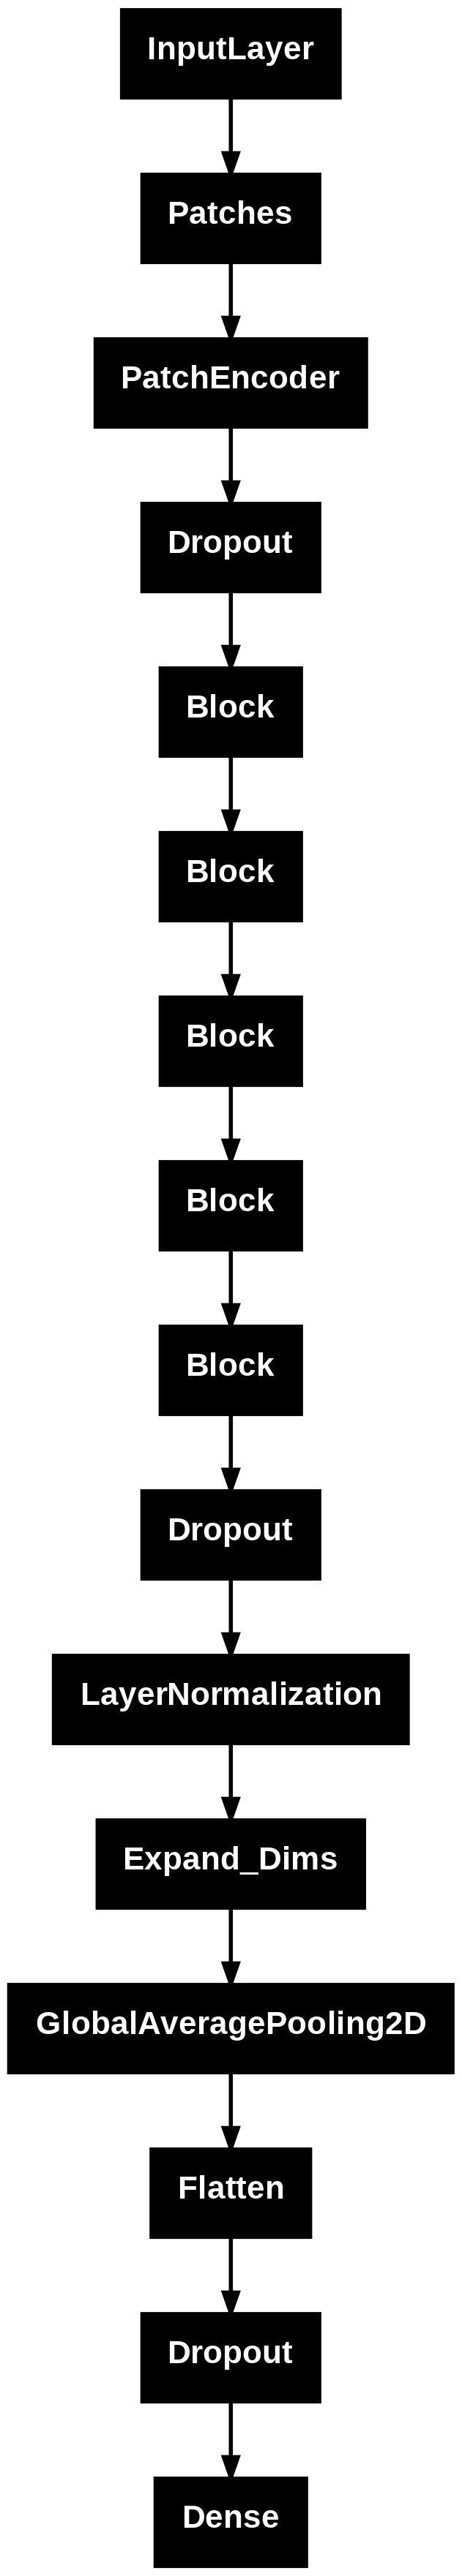

In [ ]:
# plot model architecture
plot_model(model,to_file = folder_path + "model_architecture.png", show_shapes=False)

# **Training**

Learning rate schedule: 0.0006 to 0.0006 to 1e-07


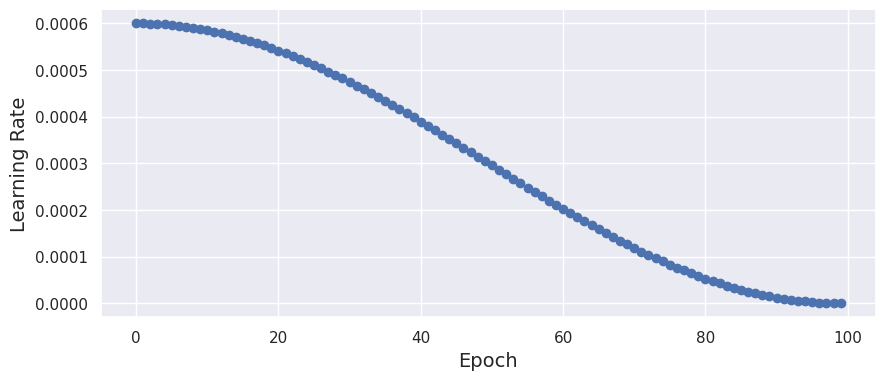

In [ ]:
LR_START = 3e-4
LR_MAX = 6e-4
LR_MIN = 1e-7
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = epoch
STEPS = [epoch,epoch*2]

def lrfn(epoch):
    if epoch<STEPS[0]:
        epoch2 = epoch
        EPOCHS2 = STEPS[0]
    elif epoch<STEPS[0]+STEPS[1]:
        epoch2 = epoch-STEPS[0]
        EPOCHS2 = STEPS[1]
    elif epoch<STEPS[0]+STEPS[1]+STEPS[2]:
        epoch2 = epoch-STEPS[0]-STEPS[1]
        EPOCHS2 = STEPS[2]

    if epoch2 < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch2 + LR_START
    elif epoch2 < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
          format(lr_y[0], max(lr_y), lr_y[-1]))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
plt.xlabel('Epoch',size=14)
plt.ylabel('Learning Rate',size=14)
plt.show()

In [ ]:
# Ensure your folder exists
os.makedirs(folder_path + "Trained models/", exist_ok=True)

# Create a valid model save path (file must end in .keras)
filepath = os.path.join(
    folder_path,
    "Trained models",
    f"{train_percent}%_ps_{P_S}.keras"  # <-- Added .keras extension
)

# Initialize your custom callback
model_shifter = Custom_callbacks(
    filepath,
    epochs=epoch,
    rate=dropout_rate,
    new_layer=Dropout_Train,
    layer_name="TRAIN_DROPOUT",
    accuracy_score=Targeted_accuracy,
    min_epochs=Min_trainable_epoch
)

# ModelCheckpoint now valid
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,  # full model gets saved in .keras format
    mode='max'
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
import time

start_time = time.time()

callbacks_list = [checkpoint, lr_callback]

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    validation_freq=1,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_list,
    shuffle=False,
    epochs=epoch,
    # Removed: use_multiprocessing=True  ❌
    # Optional: workers=1 (if you want)
)

end_time = time.time()
tt = end_time - start_time
print("✅ Total training time:", tt, "seconds")


Epoch 1: LearningRateScheduler setting learning rate to 0.0006.
Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.4770 - loss: 1.8812
Epoch 1: val_accuracy improved from -inf to 0.70835, saving model to /content/drive/MyDrive/m_p/Uncertainty in Models/Global Filter Networks/Without Pearson correlation/6_bands/Trained models/75%_ps_9.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 63s 286ms/step - accuracy: 0.4778 - loss: 1.8753 - val_accuracy: 0.7084 - val_loss: 0.7666 - learning_rate: 6.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005998489878878364.
Epoch 2/100
101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7308 - loss: 0.7023
Epoch 2: val_accuracy improved from 0.70835 to 0.83782, saving model to /content/drive/MyDrive/m_p/Uncertainty in Models/Global Filter Networks/Without Pearson correlation/6_bands/Trained models/75%_ps_9.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.7316 - loss: 0.7003 - val_accuracy: 0.8378 - val_loss: 

In [ ]:
# import os, tensorflow as tf
# from tensorflow.keras.models import load_model

# # --- Define your custom layers (at least Patches, and any others you used) ---
# class Patches(tf.keras.layers.Layer):
#     def __init__(self, patch_size=3, hidden_dim=256, patch_method='extract', **kwargs):
#         super().__init__(**kwargs)
#         self.patch_size = patch_size
#         self.hidden_dim = hidden_dim
#         self.patch_method = patch_method.lower()

#     def call(self, images):
#         if self.patch_method == "conv":
#             x = tf.keras.layers.Conv2D(self.hidden_dim, self.patch_size, self.patch_size)(images)
#             return tf.keras.layers.Reshape([-1, x.shape[-1]])(x)
#         else:
#             batch_size = tf.shape(images)[0]
#             patches = tf.image.extract_patches(
#                 images=images,
#                 sizes=[1, self.patch_size, self.patch_size, 1],
#                 strides=[1, self.patch_size, self.patch_size, 1],
#                 rates=[1, 1, 1, 1],
#                 padding="VALID",
#             )
#             patch_dims = patches.shape[-1]
#             return tf.reshape(patches, [batch_size, -1, patch_dims])

#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             "patch_size": self.patch_size,
#             "hidden_dim": self.hidden_dim,
#             "patch_method": self.patch_method
#         })
#         return config

# # --- Now load your trained model file ---
# folder_path = "<path_to_your_folder>"
# train_percent = 80
# P_S = 9

# # Ensure your filepath matches exactly the one used in ModelCheckpoint
# filepath = os.path.join(
#     folder_path,
#     "Trained models",
#     f"{train_percent}%_ps_{P_S}.keras"  # Include .keras extension
# )

# # Load the saved model
# model = load_model(filepath)


In [ ]:
###########################################

In [ ]:
Trainable_params = 0
for i in model.trainable_weights :
    Trainable_params+= np.prod(i.shape)

Non_trainable_params = 0
for i in model.non_trainable_weights:
    Non_trainable_params+= np.prod(i.shape)

Total_params = Trainable_params + Non_trainable_params
parameters_summary = [Total_params, Trainable_params, Non_trainable_params]

print("Total_params: ", Total_params)
print("Trainable_params: ", Trainable_params)
print("Non_trainable_params: ", Non_trainable_params)

Total_params:  10556513
Trainable_params:  10556513
Non_trainable_params:  0


In [ ]:
y_pred = model.predict(x_test, verbose = -1).argmax(axis = -1)

In [ ]:
y_pred.shape, y_test.shape

((4310,), (4310,))

In [ ]:
#performance_meausures(y_test, y_pred, tt, *parameters_summary, folder_path = folder_path)

In [ ]:
for _ in range(5):
    gc.collect()

In [ ]:
for i in model.trainable_weights:
    if "weighted_add_weighted_add" in str(i):
        print(f"{i.name[13:]}  ------> {i.numpy()[0,0,0]}")

In [ ]:
filepath1 = folder_path +"Results/"+ str(train_percent)+"% ps_" +str(P_S) + " performance" + ".txt"
results = confusion_matrix(y_test,y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print(" ", file = open(filepath1, "a"))
print("P_S = ", P_S, file = open(filepath1, "a"))
print('Confusion Matrix :', file=open(filepath1,"a"))
print(results, file=open(filepath1,"a"))

print('Report : ', file=open(filepath1,"a"))
print(report, file=open(filepath1,"a"))

print('Accuracy Score :', accuracy, file=open(filepath1,"a"))
print('Cohen_Kappa: ', kappa, file=open(filepath1,"a"))
print('Training Time:', tt, file=open(filepath1,"a"))

print("\033[1m", 'Confusion Matrix :', "\033[0m")
print(results)
print("\033[1m", 'Report : ', "\033[0m")
print(report)
print("\033[1m", 'Accuracy Score :', "\033[0m", accuracy)
print("\033[1m", 'Cohen_Kappa: ',  "\033[0m", kappa)
print("\033[1m", 'Training Time:', "\033[0m", tt)
print("\033[1m", "Total_params: ", "\033[0m", Total_params)
print("\033[1m", "Trainable_params: ", "\033[0m", Trainable_params)
print("\033[1m", "Non_trainable_params: ", "\033[0m", Non_trainable_params)

In [ ]:
y_test = y_test.reshape(y_test.shape[0],1)
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_pred = y_pred.astype(int)
y_combined = np.concatenate((y_test,y_pred),axis=1)
img_path = folder_path + "Results/"+ str(train_percent) + "% ps_" +str(P_S) + " test_vs_pred.csv"
 #filepath_1 = "/content/drive/My Drive/m_p/Global Filter Networks Comparitive Study/372 band/Simple Models/Results/
np.savetxt(img_path, y_combined, delimiter=",")

In [ ]:
img_path = folder_path + str(train_percent) + "% ps_" +str(P_S) + " predicted_image.png"
prob_file_path = folder_path + "Results/" + "class probabilities.csv"
try:
    y_hat = plt.imread(img_path)
except:
    y_prob = probabilistic_outputs(model, padded_x, H, W, B, P_S)
    y_hat = y_prob.argmax(axis = -1) + 1
    spectral.save_rgb(img_path, y_hat.reshape((H,W)), colors = spectral.spy_colors)
    np.savetxt(prob_file_path, y_prob.reshape((-1, num_classes)), delimiter=",")

In [ ]:
a_c = np.unique(y_hat,return_counts=True)
print(a_c)
print(a_c,file=open(filepath1,"a"))

In [ ]:
img_path = folder_path + str(train_percent) + "% ps_" +str(P_S) + " predicted_image.png"
spectral.save_rgb("available_image.png", y, colors = spectral.spy_colors)

In [ ]:
# img_path = folder_path + "Results/" + str(train_percent) + "% ps_" +str(P_S) + " predicted_image.png"
# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize = (12, int(np.ceil(12*W/H*2))))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize = (10, 20))

img = plt.imread(img_path)
ax1.imshow(plt.imread(img_path))
ax1.set_title(f"Predicted image P_S = {P_S}")
ax1.axis("off")

ax2.imshow(Approximate_rgb_img.astype("int"))
ax2.set_title("approximate rgb image")
ax2.axis("off")

plt.tight_layout(pad = 0, h_pad=0, w_pad=0.2)
plt.show()

image predicted ███████████████ 50%
image predicted ███████████████████████████████ 100%
Time taken: 0.70 min


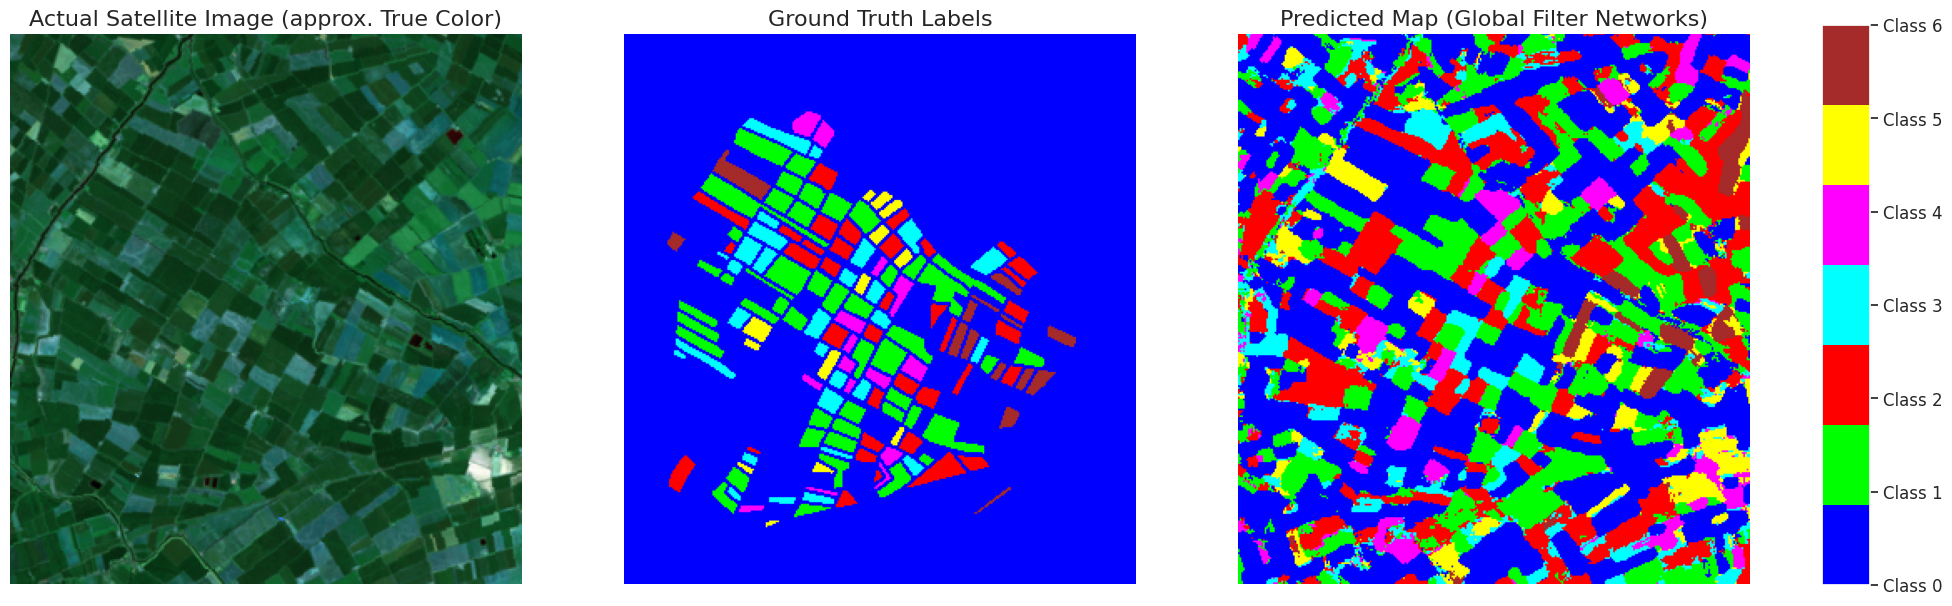

✅ Figure displayed and saved to Excel:
/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Global Filter Networks/6 bands/ClassWiseCP/conformal_reports.xlsx


In [ ]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as XLImage
import pandas as pd

# Define ViT-style color map
vit_style_colors = [
    '#0000FF', # Blue
    '#00FF00', # Green
    '#FF0000', # Red
    '#00FFFF', # Cyan
    '#FF00FF', # Magenta
    '#FFFF00', # Yellow
    '#A52A2A', # Brown
]
better_cmap = ListedColormap(vit_style_colors)


# ------------------------------------------------------------------
# Model Prediction
# ------------------------------------------------------------------
def predict_prob_half_image(model, padded_x, H, W_range, B, P_S, num_classes):
    y_hat_probs = np.zeros((H, W_range, num_classes))
    for j in range(W_range):
        patchs = np.zeros((H, P_S, P_S, B))
        for i in range(H):
            patchs[i, :, :, :] = padded_x[i:i + P_S, j:j + P_S, :]
        y_pred_probs = model.predict(patchs, verbose=0)
        y_hat_probs[:, j, :] = y_pred_probs
    return y_hat_probs


def predict_probabilities_image(model, padded_x, H, W, B, P_S, num_classes):
    import time, gc
    start_time = time.time()
    pad_width = int((P_S - 1) / 2)
    half_1 = padded_x.shape[1] // 2 + pad_width + 1
    half_2 = padded_x.shape[1] // 2 - pad_width - 1
    padded_x_1st_half = padded_x[:, :half_1, :]
    padded_x_2nd_half = padded_x[:, half_2:, :]
    del padded_x; gc.collect()
    y_hat_all_probs = np.zeros((H, W, num_classes))

    # Half 1
    y_hat_all_probs[:, :W // 2, :] = predict_prob_half_image(model, padded_x_1st_half, H, W // 2, B, P_S, num_classes)
    print("image predicted ███████████████ 50%")

    # Half 2
    y_hat_all_probs[:, W // 2:, :] = predict_prob_half_image(model, padded_x_2nd_half, H, W - (W // 2), B, P_S, num_classes)
    print("image predicted ███████████████████████████████ 100%")

    end_time = time.time()
    print(f"Time taken: {(end_time - start_time) / 60:.2f} min")
    return y_hat_all_probs


# ------------------------------------------------------------------
# Visualization + Excel export
# ------------------------------------------------------------------
def visualize_and_save_to_excel(model, padded_x, x, y, H, W, B, P_S, num_classes,
                                save_dir, filename="conformal_reports.xlsx"):
    # Predict
    prob_pred = predict_probabilities_image(model, padded_x, H, W, B, P_S, num_classes)
    pred_class = np.argmax(prob_pred, axis=2)

    # Prepare RGB image (example: bands 2, 4, 5)
    rgb_bands_indices = [2, 4, 5]
    rgb_image = (x[:, :, rgb_bands_indices] * 255).astype("uint8")
    rgb_norm = rgb_image / 255.0  # Normalize for imshow

    # Create side-by-side comparison figure
    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)

    # Image 1: True-color Satellite
    axes[0].imshow(rgb_norm)
    axes[0].set_title("Actual Satellite Image (approx. True Color)", fontsize=16)
    axes[0].axis("off")

    # Image 2: Ground Truth
    axes[1].imshow(y, cmap=better_cmap, vmin=0, vmax=num_classes-1)
    axes[1].set_title("Ground Truth Labels", fontsize=16)
    axes[1].axis("off")

    # Image 3: Prediction Map
    im = axes[2].imshow(pred_class, cmap=better_cmap, vmin=0, vmax=num_classes-1)
    axes[2].set_title("Predicted Map (Global Filter Networks)", fontsize=16)
    axes[2].axis("off")

    # Shared colorbar
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(num_classes))
    cbar.set_ticklabels([f"Class {i}" for i in range(num_classes)])
    cbar.ax.tick_params(labelsize=12)

    # ➡️ SHOW FIGURE in the notebook / script (like before)
    plt.show()

    # Also SAVE to Excel
    os.makedirs(save_dir, exist_ok=True)

    img_buffer = io.BytesIO()
    fig.savefig(img_buffer, format="png", bbox_inches="tight")
    img_buffer.seek(0)
    plt.close(fig)

    excel_path = os.path.join(save_dir, filename)

    # Create or append Excel file
    if not os.path.exists(excel_path):
        df = pd.DataFrame({"Info": ["Global Filter Networks Model Output"]})
        df.to_excel(excel_path, index=False)
        wb = load_workbook(excel_path)
    else:
        wb = load_workbook(excel_path)

    ws = wb.create_sheet(title=f"Run_{len(wb.sheetnames)}")
    xl_img = XLImage(img_buffer)
    xl_img.anchor = "A1"
    ws.add_image(xl_img)

    ws["C40"] = "Saved by Global Filter Networks script"
    ws["C41"] = "Displayed and exported successfully"

    wb.save(excel_path)
    print(f"✅ Figure displayed and saved to Excel:\n{excel_path}")


visualize_and_save_to_excel(
    model, padded_x, x, y, H, W, B, P_S, num_classes,
    save_dir="/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Global Filter Networks/6 bands/ClassWiseCP/"
)

#  **Split Conformal Prediction**

Calibration set size: 2155 | Test set size: 2155
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

✅ Softmax probabilities generated. Inference time: 3.06s

--- Standard Split Conformal Prediction Results ---
Target Coverage: 0.950
Empirical Test Coverage: 0.952
Average Prediction Set Size: 0.952

✅ Graph saved to 'Per-Class Coverage' in '/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Global Filter Networks/6 bands/ClassWiseCP/conformal_reports.xlsx'


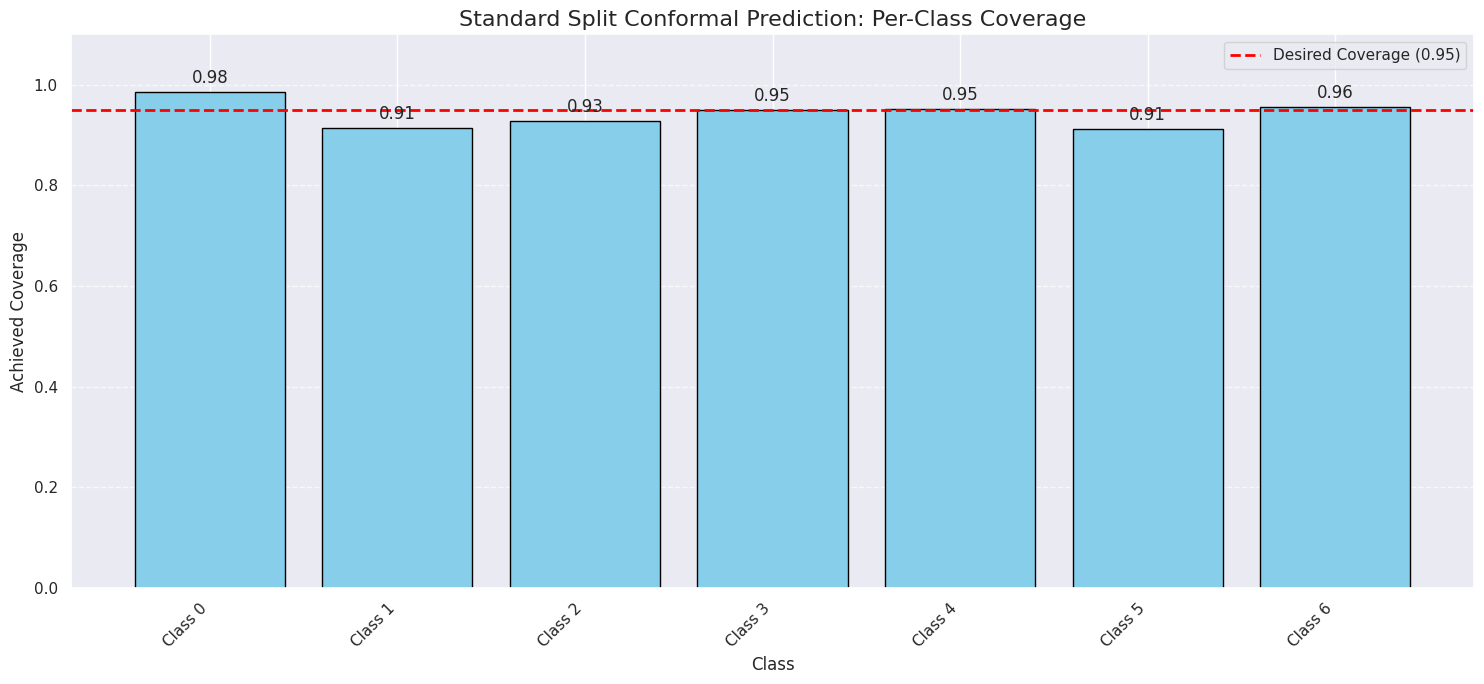

In [ ]:
# --- ADDED: Install & imports for Excel handling ---
!pip install openpyxl --quiet

import os
import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import time
import openpyxl
from openpyxl.drawing.image import Image as OpenPyXLImage

# ✅ DEFINE SAVE SETTINGS
output_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Global Filter Networks/6 bands/ClassWiseCP/"
excel_filename = "conformal_reports.xlsx"
excel_file_path = os.path.join(output_dir, excel_filename)
sheet_name = "Per-Class Coverage"

os.makedirs(output_dir, exist_ok=True)

# --- 1. Split Original Test Set into Calibration & Evaluation Sets ---
x_test_np = x_test.numpy() if hasattr(x_test, "numpy") else x_test
y_test_np = y_test.numpy() if hasattr(y_test, "numpy") else y_test

x_calib_np, x_test_new_np, y_calib_np, y_test_new_np = train_test_split(
    x_test_np, y_test_np, test_size=0.5, stratify=y_test_np, random_state=42
)

print(f"Calibration set size: {len(x_calib_np)} | Test set size: {len(x_test_new_np)}")

# --- 2. Get Model Probabilities ---
start_time = time.time()
calib_probs = model.predict(x_calib_np, batch_size=64, verbose=1)
test_probs = model.predict(x_test_new_np, batch_size=64, verbose=1)
end_time = time.time()
print(f"\n✅ Softmax probabilities generated. Inference time: {end_time - start_time:.2f}s")

# --- 3. Split Conformal Prediction Calibration ---
alpha = 0.05
n_calib = len(y_calib_np)

calib_scores_split = 1 - calib_probs[np.arange(n_calib), y_calib_np]
q_level_split = np.ceil((n_calib + 1) * (1 - alpha)) / n_calib
q_hat_split = np.quantile(calib_scores_split, q_level_split, method="higher")

prediction_sets_split = test_probs >= (1 - q_hat_split)

empirical_coverage_split = (
    prediction_sets_split[np.arange(len(y_test_new_np)), y_test_new_np]
).mean()
avg_set_size_split = prediction_sets_split.sum(axis=1).mean()

print("\n--- Standard Split Conformal Prediction Results ---")
print(f"Target Coverage: {1-alpha:.3f}")
print(f"Empirical Test Coverage: {empirical_coverage_split:.3f}")
print(f"Average Prediction Set Size: {avg_set_size_split:.3f}")

# --- 4. Per-Class Coverage Plot ---
num_classes = test_probs.shape[1]
class_labels = [f"Class {i}" for i in range(num_classes)]
coverages_split = []

y_test_new_np = np.array(y_test_new_np).reshape(-1)
for i in range(num_classes):
    class_mask = (y_test_new_np == i)
    if class_mask.sum() == 0:
        coverages_split.append(np.nan)
        continue
    coverages_split.append(prediction_sets_split[class_mask, i].mean())

coverages_split = np.array(coverages_split)

# --- 5. Plot Coverage Bar Chart ---
plt.figure(figsize=(15, 7))
bars = plt.bar(class_labels, coverages_split, color="skyblue", edgecolor="black")

for bar in bars:
    yval = bar.get_height()
    if not np.isnan(yval):
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.01, f"{yval:.2f}",
                 ha="center", va="bottom")

plt.axhline(y=(1 - alpha), color="red", linestyle="--", linewidth=2,
            label=f"Desired Coverage ({1-alpha:.2f})")

plt.title("Standard Split Conformal Prediction: Per-Class Coverage", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Achieved Coverage", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# --- 6. Save Plot to Excel ---
image_buffer = io.BytesIO()
plt.savefig(image_buffer, format="png", bbox_inches="tight")
image_buffer.seek(0)

if os.path.exists(excel_file_path):
    workbook = openpyxl.load_workbook(excel_file_path)
    if sheet_name in workbook.sheetnames:
        del workbook[sheet_name]
    sheet = workbook.create_sheet(title=sheet_name)
else:
    workbook = openpyxl.Workbook()
    sheet = workbook.active
    sheet.title = sheet_name

img = OpenPyXLImage(image_buffer)
sheet.add_image(img, "A1")
workbook.save(excel_file_path)

print(f"\n✅ Graph saved to '{sheet_name}' in '{excel_file_path}'")

plt.show()
plt.close(plt.gcf())

ℹ️ Generating prob_pred using model.predict_probabilities_image(...)
image predicted ███████████████ 50%
image predicted ███████████████████████████████ 100%
Time taken: 0.97 min
ℹ️ Creating class predictions (pred_class) from prob_pred using argmax...


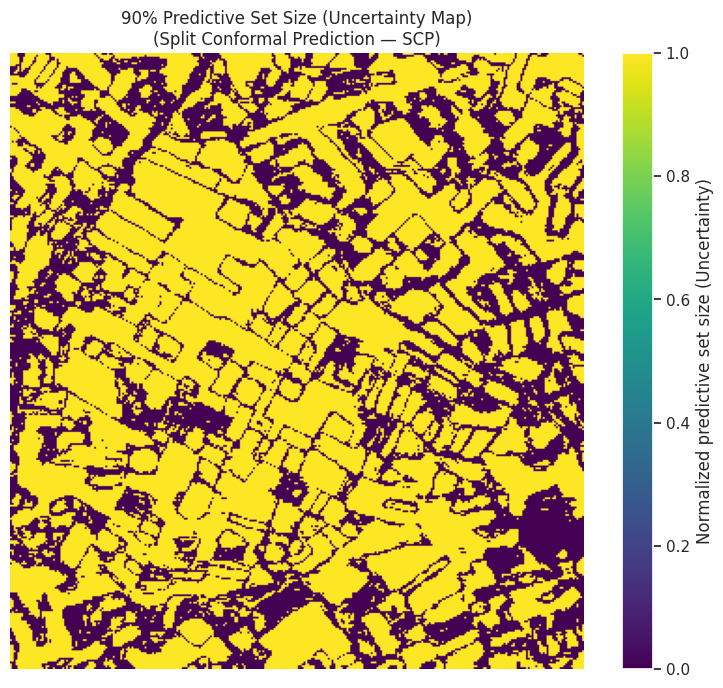

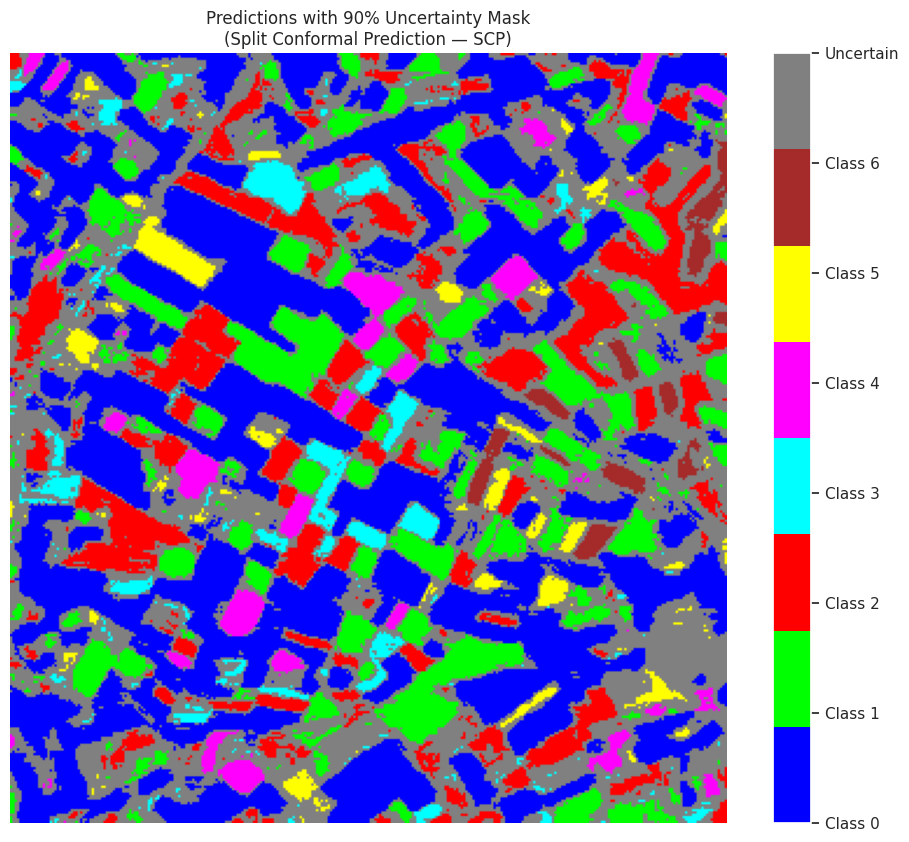

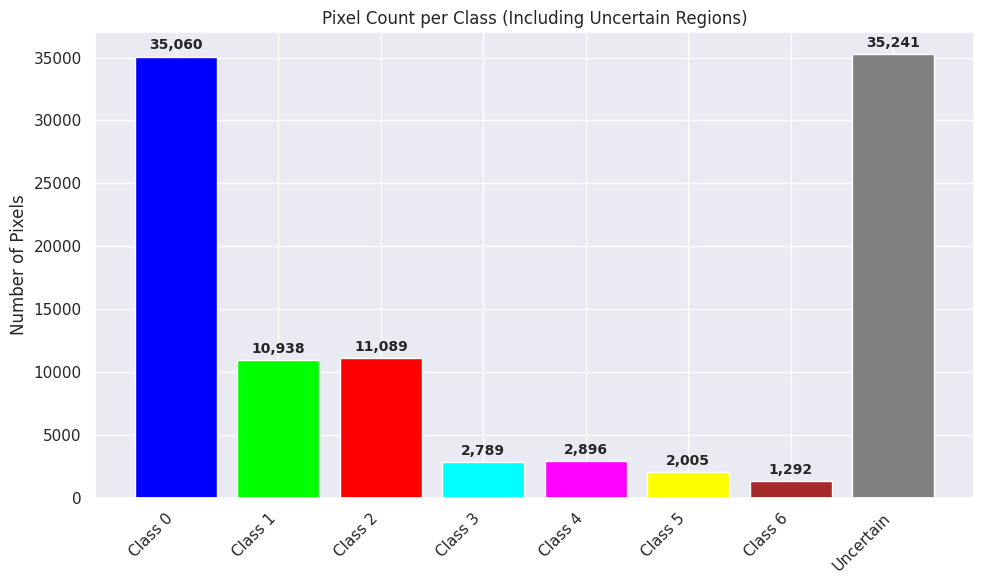

✅ Plots displayed and saved successfully to Excel:
/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Global Filter Networks/6 bands/ClassWiseCP/conformal_reports.xlsx


In [ ]:
# -------------------------------------------------------
# 🟧 UNCERTAINTY MAPS VISUALIZATION — Split Conformal Prediction (SCP)
# -------------------------------------------------------

import os
import io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from openpyxl import Workbook, load_workbook
from openpyxl.drawing.image import Image as XLImage

# -------------------------------------------------------
# 🔧 Settings
# -------------------------------------------------------
output_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Global Filter Networks/6 bands/ClassWiseCP/"
excel_filename = "conformal_reports.xlsx"
excel_path = os.path.join(output_dir, excel_filename)
os.makedirs(output_dir, exist_ok=True)

# -------------------------------------------------------
# ✅ STEP 1. Ensure required variables exist
# -------------------------------------------------------
required = ["model", "H", "W", "B", "P_S", "num_classes"]
for v in required:
    if v not in locals():
        raise NameError(f"❌ Variable '{v}' is missing. Please define it before running this cell.")

# If prob_pred is missing, generate it
if "prob_pred" not in locals():
    print("ℹ️ Generating prob_pred using model.predict_probabilities_image(...)")
    prob_pred = predict_probabilities_image(model, padded_x, H, W, B, P_S, num_classes)

# If pred_class is missing, compute it from prob_pred
if "pred_class" not in locals():
    print("ℹ️ Creating class predictions (pred_class) from prob_pred using argmax...")
    pred_class = np.argmax(prob_pred, axis=-1)

# Likewise, ensure q_hat_split exists
if "q_hat_split" not in locals():
    raise NameError("❌ 'q_hat_split' is missing. Please run your calibration cell first to compute it.")

# -------------------------------------------------------
# ✅ STEP 2. Compute predictive-set sizes (auto 2D/3D)
# -------------------------------------------------------
predictive_sets = prob_pred > (1 - q_hat_split)
if predictive_sets.ndim == 3:
    set_sizes = np.sum(predictive_sets, axis=2)
elif predictive_sets.ndim == 2:
    set_sizes = np.sum(predictive_sets, axis=1)
    if "H" in locals() and "W" in locals() and H * W == set_sizes.size:
        set_sizes = set_sizes.reshape(H, W)
        pred_class = pred_class.reshape(H, W)
    else:
        print("⚠️ Could not reshape set_sizes to image grid; using flattened form.")
else:
    raise ValueError(f"Unexpected array shape {predictive_sets.shape} — expected 2D or 3D.")

# -------------------------------------------------------
# 🌈 STEP 3. Normalize predictive-set sizes
# -------------------------------------------------------
norm_set_sizes = (set_sizes - set_sizes.min()) / (set_sizes.max() - set_sizes.min())

# -------------------------------------------------------
# 🎨 STEP 4. Predictive Set Size (Uncertainty Map)
# -------------------------------------------------------
fig1 = plt.figure(figsize=(10, 8))
plt.imshow(norm_set_sizes, cmap="viridis")
plt.colorbar(label="Normalized predictive set size (Uncertainty)")
plt.title("90% Predictive Set Size (Uncertainty Map)\n(Split Conformal Prediction — SCP)")
plt.axis("off")
plt.show()

buf1 = io.BytesIO()
fig1.savefig(buf1, format="png", bbox_inches="tight")
buf1.seek(0)
plt.close(fig1)

# -------------------------------------------------------
# 🎭 STEP 5. Masked Prediction Map with Uncertain Regions
# -------------------------------------------------------
vit_colors = ['#0000FF', '#00FF00', '#FF0000', '#00FFFF', '#FF00FF', '#FFFF00', '#A52A2A']
custom_cmap = ListedColormap(vit_colors + ['#808080'])  # gray = uncertain

combined_map = np.where(set_sizes == 1, pred_class, num_classes)

fig2 = plt.figure(figsize=(12, 10))
plt.imshow(combined_map, cmap=custom_cmap)
plt.title("Predictions with 90% Uncertainty Mask\n(Split Conformal Prediction — SCP)")

cbar = plt.colorbar(ticks=np.arange(num_classes + 1))
cbar.set_ticklabels([f"Class {i}" for i in range(num_classes)] + ["Uncertain"])
plt.axis("off")
plt.show()

buf2 = io.BytesIO()
fig2.savefig(buf2, format="png", bbox_inches="tight")
buf2.seek(0)
plt.close(fig2)

# -------------------------------------------------------
# 📊 STEP 6. Bar Chart — Pixel Counts per Class
# -------------------------------------------------------
unique_classes, counts = np.unique(combined_map, return_counts=True)
labels = [f"Class {i}" for i in range(num_classes)] + ["Uncertain"]
pixel_counts = [counts[unique_classes == i][0] if i in unique_classes else 0
                for i in range(num_classes + 1)]

fig3 = plt.figure(figsize=(10, 6))
bars = plt.bar(labels, pixel_counts, color=list(vit_colors) + ['#808080'])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Pixels")
plt.title("Pixel Count per Class (Including Uncertain Regions)")

# add numeric pixel counts on top of bars
for bar, count in zip(bars, pixel_counts):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + (max(pixel_counts)*0.01 if max(pixel_counts) else 1),
             f"{count:,}", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

buf3 = io.BytesIO()
fig3.savefig(buf3, format="png", bbox_inches="tight")
buf3.seek(0)
plt.close(fig3)

# -------------------------------------------------------
# 💾 STEP 7. Save All Three Figures to Excel
# -------------------------------------------------------
if not os.path.exists(excel_path):
    wb = Workbook()
    ws = wb.active
    ws.title = "Info"
    ws["A1"] = "Conformal Prediction Reports"
    ws["A2"] = "Created automatically by visualization script"
    wb.save(excel_path)
    print(f"Created new Excel file at {excel_path}")

wb = load_workbook(excel_path)
sheet_name = f"SCP_Run_{len(wb.sheetnames)}"
ws = wb.create_sheet(title=sheet_name)

xl_img1, xl_img2, xl_img3 = XLImage(buf1), XLImage(buf2), XLImage(buf3)
xl_img1.anchor, xl_img2.anchor, xl_img3.anchor = "A1", "N1", "A25"
for img in [xl_img1, xl_img2, xl_img3]:
    ws.add_image(img)

ws["A48"] = "Saved by SCP Visualization Script"
ws["A49"] = "Includes Uncertainty Map, Masked Prediction Map, and Class Distribution"

wb.save(excel_path)
print(f"✅ Plots displayed and saved successfully to Excel:\n{excel_path}")

# **Class wise Conformal Prediction**


--- Starting Class-wise Conformal Prediction ---
Size of calibration set: 2155
Size of new test set: 2155
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Inference time: 0.94 seconds

Calibrating per class...

--- Results ---
Target Coverage: 0.950
Empirical Coverage: 0.953
Average Prediction Set Size: 0.953
Saved plot to 'Classwise Coverage' in '/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Global Filter Networks/6 bands/ClassWiseCP/conformal_reports.xlsx'


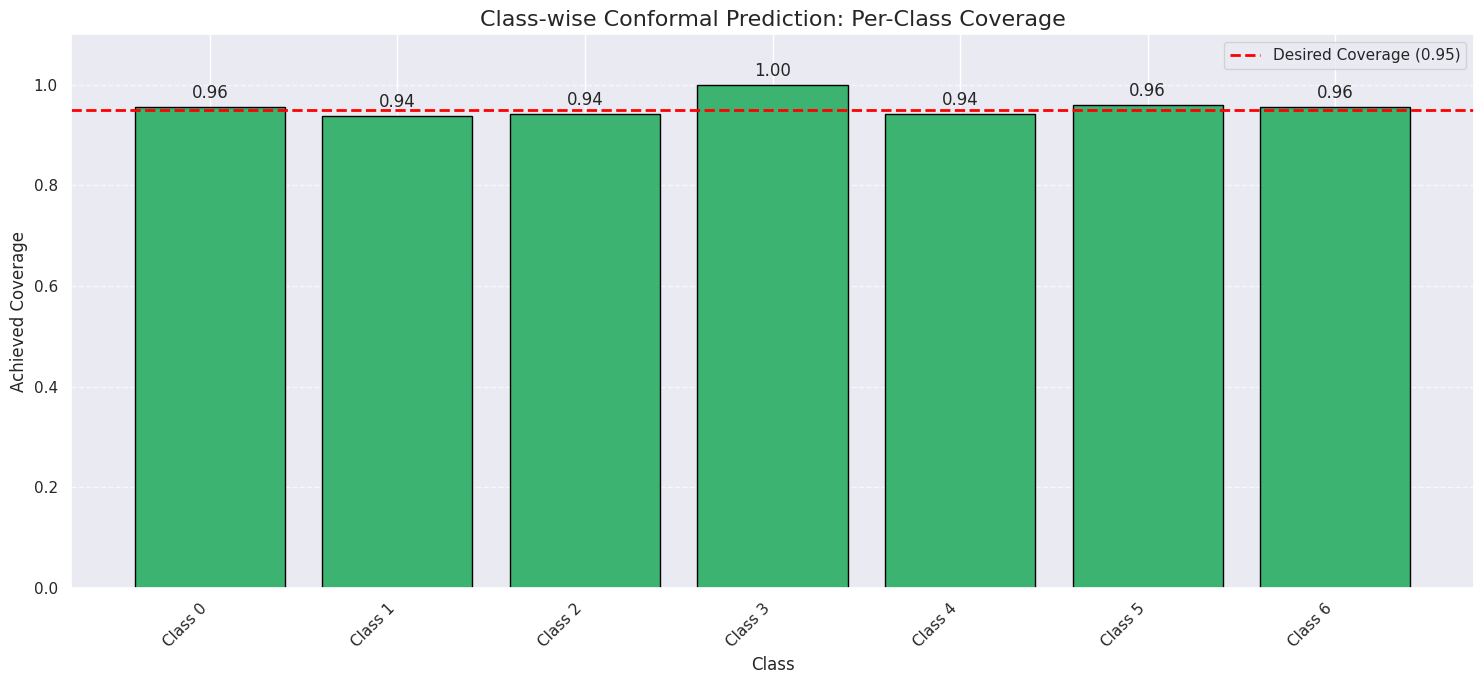

In [ ]:
# -------------------------------------------------------
# CLASS-WISE CONFORMAL PREDICTION (Generates thresholds + Excel plot)
# -------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf
import os, io, openpyxl
from openpyxl.drawing.image import Image as OpenPyXLImage


def classwise_conformal_prediction_keras(model, x_test, y_test, alpha=0.05, batch_size=64):
    """
    Performs class-wise Conformal Prediction uncertainty analysis using a Keras model.
    Returns q_hats_classwise so later visualization can reuse thresholds.
    """

    print("\n--- Starting Class-wise Conformal Prediction ---")

    # 1️ Split test data into calibration and evaluation sets
    x_calib, x_test_new, y_calib, y_test_new = train_test_split(
        np.array(x_test), np.array(y_test),
        test_size=0.5, stratify=y_test, random_state=42
    )
    y_calib = y_calib.reshape(-1)
    y_test_new = y_test_new.reshape(-1)

    print(f"Size of calibration set: {len(x_calib)}")
    print(f"Size of new test set: {len(x_test_new)}")

    # 2️ Generate softmax probabilities using the Keras model
    start_time = time.time()
    calib_probs = model.predict(x_calib, batch_size=batch_size, verbose=1)
    test_probs = model.predict(x_test_new, batch_size=batch_size, verbose=1)
    end_time = time.time()
    print(f"Inference time: {end_time - start_time:.2f} seconds")

    # 3️ Compute per-class quantiles (class-wise calibration)
    num_classes = calib_probs.shape[1]
    q_hats_classwise = np.zeros(num_classes)

    print("\nCalibrating per class...")
    for i in range(num_classes):
        mask = (y_calib == i)
        if mask.sum() == 0:
            q_hats_classwise[i] = 1.0
            continue
        scores = 1 - calib_probs[mask, i]
        n_i = mask.sum()
        q_level = np.ceil((n_i + 1) * (1 - alpha)) / n_i
        q_hats_classwise[i] = np.quantile(scores, q_level, method="higher")

    # 4️⃣ Prediction sets & evaluation
    conf_thresholds = 1 - q_hats_classwise
    prediction_sets_cw = test_probs >= conf_thresholds

    empirical_coverage_cw = (
        prediction_sets_cw[np.arange(len(y_test_new)), y_test_new]
    ).mean()
    avg_set_size_cw = prediction_sets_cw.sum(axis=1).mean()

    print("\n--- Results ---")
    print(f"Target Coverage: {1-alpha:.3f}")
    print(f"Empirical Coverage: {empirical_coverage_cw:.3f}")
    print(f"Average Prediction Set Size: {avg_set_size_cw:.3f}")

    # 5️⃣ Per-class coverage plot
    coverages_classwise = []
    for i in range(num_classes):
        class_mask = (y_test_new == i)
        if class_mask.sum() == 0:
            coverages_classwise.append(np.nan)
            continue
        sets_i = prediction_sets_cw[class_mask]
        coverages_classwise.append(sets_i[:, i].mean())
    coverages_classwise = np.array(coverages_classwise)

    class_labels = [f"Class {i}" for i in range(num_classes)]
    plt.figure(figsize=(15, 7))
    bars = plt.bar(class_labels, coverages_classwise, color="mediumseagreen", edgecolor="black")
    for bar in bars:
        yval = bar.get_height()
        if not np.isnan(yval):
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}",
                     ha="center", va="bottom")
    plt.axhline(y=(1-alpha), color="red", linestyle="--", linewidth=2,
                label=f"Desired Coverage ({1-alpha:.2f})")
    plt.title("Class-wise Conformal Prediction: Per-Class Coverage", fontsize=16)
    plt.xlabel("Class"); plt.ylabel("Achieved Coverage")
    plt.xticks(rotation=45, ha="right"); plt.ylim(0, 1.1)
    plt.legend(); plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    # 6️⃣ Save plot to Excel
    output_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Global Filter Networks/6 bands/ClassWiseCP/"
    excel_filename = "conformal_reports.xlsx"
    excel_path = os.path.join(output_dir, excel_filename)
    sheet_name = "Classwise Coverage"

    try:
        os.makedirs(output_dir, exist_ok=True)
        buf = io.BytesIO(); plt.savefig(buf, format="png", bbox_inches="tight"); buf.seek(0)
        if os.path.exists(excel_path):
            wb = openpyxl.load_workbook(excel_path)
            if sheet_name in wb.sheetnames: del wb[sheet_name]
            sheet = wb.create_sheet(title=sheet_name)
        else:
            wb = openpyxl.Workbook(); sheet = wb.active; sheet.title = sheet_name
        img = OpenPyXLImage(buf); sheet.add_image(img, "A1"); wb.save(excel_path)
        print(f"Saved plot to '{sheet_name}' in '{excel_path}'")
    except Exception as e:
        print(f"Excel save failed: {e}")

    plt.show(); plt.close()

    # 7️⃣ Return metrics + thresholds
    return {
        "coverage": empirical_coverage_cw,
        "avg_set_size": avg_set_size_cw,
        "per_class_coverages": coverages_classwise,
        "q_hats_classwise": q_hats_classwise
    }

# Run calibration
results = classwise_conformal_prediction_keras(model, x_test, y_test, alpha=0.05, batch_size=64)
q_hats_classwise = results["q_hats_classwise"]

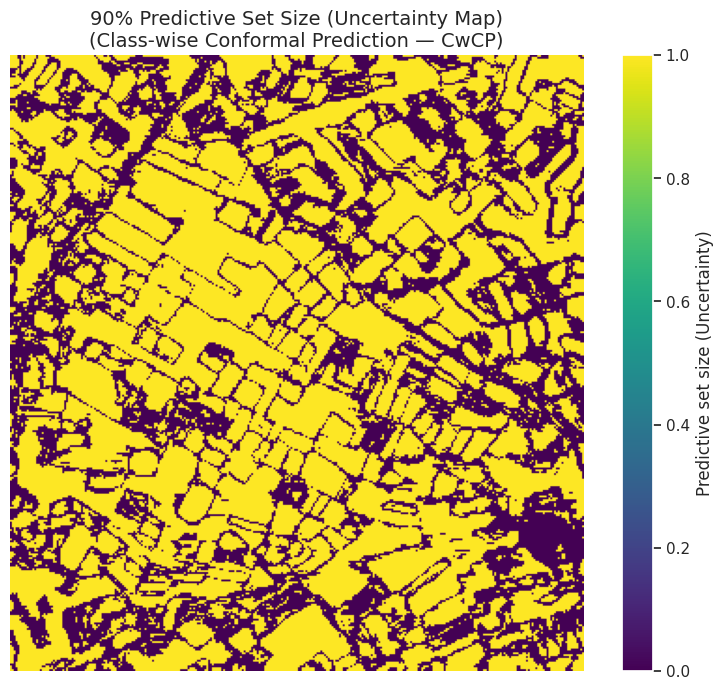

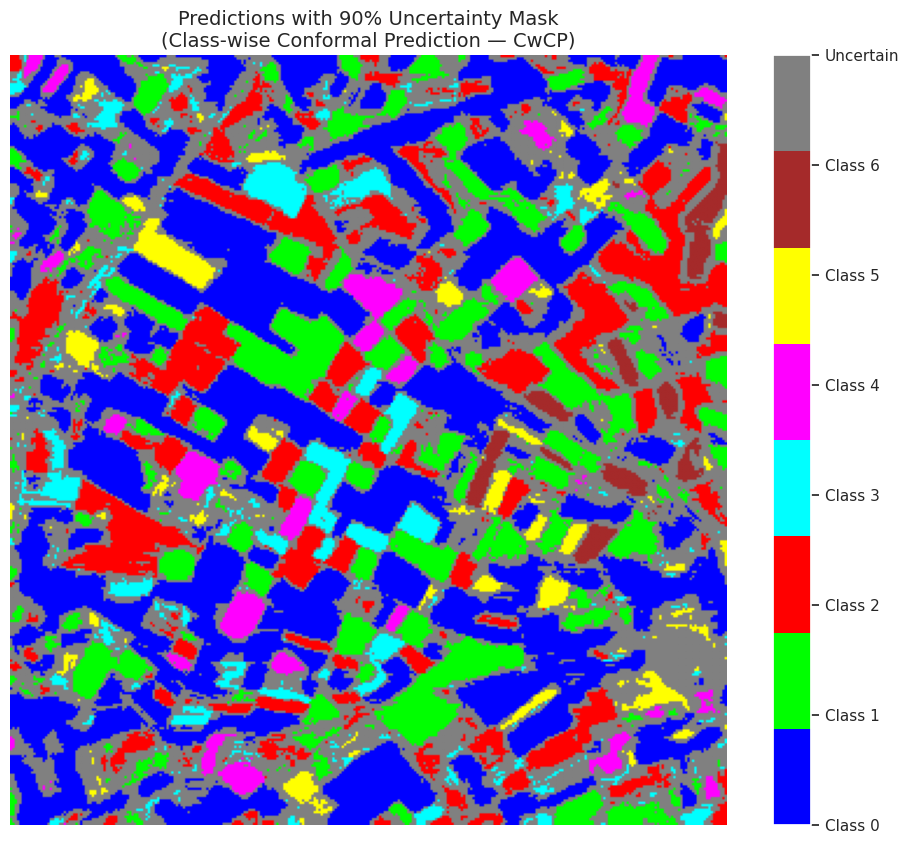

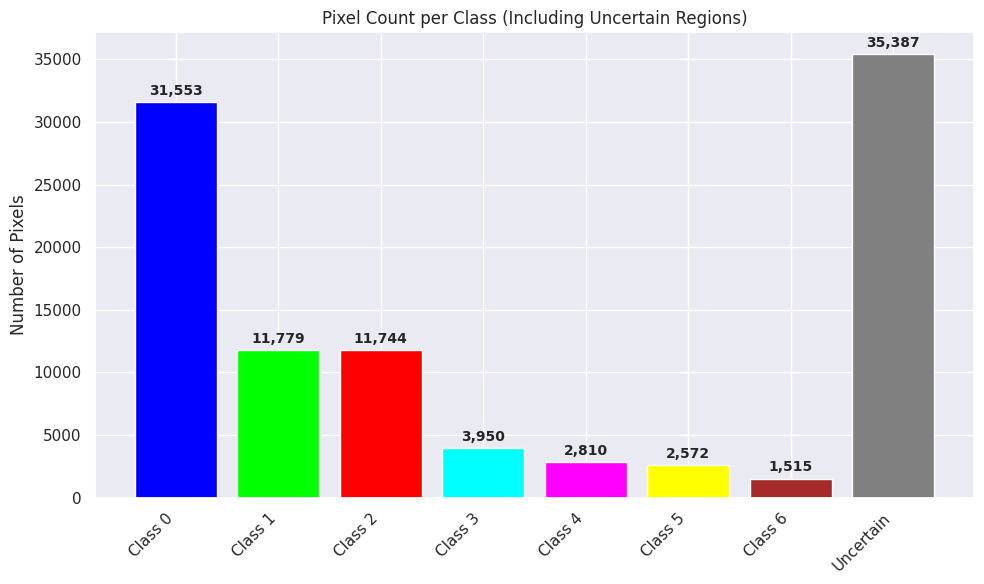

✅ Plots displayed & saved to Excel:
/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Global Filter Networks/6 bands/ClassWiseCP/conformal_reports.xlsx


In [ ]:
# -------------------------------------------------------
# 🟧 UNCERTAINTY MAPS VISUALIZATION — Class-wise Conformal Prediction (CwCP)
# -------------------------------------------------------

import os
import io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from openpyxl import Workbook, load_workbook
from openpyxl.drawing.image import Image as XLImage

# -------------------------------------------------------
# 🔧 Settings
# -------------------------------------------------------
output_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Global Filter Networks/6 bands/ClassWiseCP/"
excel_filename = "conformal_reports.xlsx"
excel_path = os.path.join(output_dir, excel_filename)
os.makedirs(output_dir, exist_ok=True)

# -------------------------------------------------------
# ✅ Use existing predictions & thresholds
# -------------------------------------------------------
num_classes = prob_pred.shape[-1]
q_hats_classwise = np.array(q_hats_classwise).reshape(1, 1, num_classes)

# Compute predictive sets and set sizes (uncertainty measure)
predictive_sets_cw = prob_pred >= (1 - q_hats_classwise)
set_sizes_cw = np.sum(predictive_sets_cw, axis=2)

# Normalize 0‑1 for visualization
norm_set_sizes = (set_sizes_cw - np.min(set_sizes_cw)) / (np.max(set_sizes_cw) - np.min(set_sizes_cw))

# -------------------------------------------------------
# 🎨 1️⃣ Predictive Set Size (Uncertainty Map — reversed color)
# -------------------------------------------------------
fig1 = plt.figure(figsize=(10, 8))
plt.imshow(norm_set_sizes, cmap="viridis")   # reversed viridis
plt.colorbar(label="Predictive set size (Uncertainty)")
plt.title("90% Predictive Set Size (Uncertainty Map)\n(Class-wise Conformal Prediction — CwCP)", fontsize=14)
plt.axis("off")
plt.show()

buf1 = io.BytesIO()
fig1.savefig(buf1, format="png", bbox_inches="tight")
buf1.seek(0)
plt.close(fig1)

# -------------------------------------------------------
# 🎭 2️⃣ Masked Prediction Map with Uncertain Regions
# -------------------------------------------------------
vit_style_colors = [
    "#0000FF", "#00FF00", "#FF0000",
    "#00FFFF", "#FF00FF", "#FFFF00", "#A52A2A"
]
custom_cmap = ListedColormap(vit_style_colors + ["#808080"])  # gray = uncertain

# Mark uncertain pixels (set_size > 1 => uncertain)
combined_map_cw = np.where(set_sizes_cw == 1, pred_class, num_classes)

fig2 = plt.figure(figsize=(12, 10))
plt.imshow(combined_map_cw, cmap=custom_cmap)
plt.title("Predictions with 90% Uncertainty Mask\n(Class-wise Conformal Prediction — CwCP)", fontsize=14)

cbar = plt.colorbar(ticks=np.arange(num_classes + 1))
cbar.set_ticklabels([f"Class {i}" for i in range(num_classes)] + ["Uncertain"])
plt.axis("off")
plt.show()

buf2 = io.BytesIO()
fig2.savefig(buf2, format="png", bbox_inches="tight")
buf2.seek(0)
plt.close(fig2)

# -------------------------------------------------------
# 📊 3️⃣ Bar Chart — Pixel Counts per Class (including Uncertain)
# -------------------------------------------------------
unique_classes, counts = np.unique(combined_map_cw, return_counts=True)
labels = [f"Class {i}" for i in range(num_classes)] + ["Uncertain"]

# Ensure every label index appears
pixel_counts = [counts[unique_classes == i][0] if i in unique_classes else 0
                for i in range(num_classes + 1)]

fig3 = plt.figure(figsize=(10, 6))
bars = plt.bar(labels, pixel_counts, color=list(vit_style_colors) + ['#808080'])

plt.ylabel("Number of Pixels")
plt.xticks(rotation=45, ha="right")
plt.title("Pixel Count per Class (Including Uncertain Regions)")

# Add numeric count above each bar
for bar, count in zip(bars, pixel_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + max(pixel_counts)*0.01,
             f"{count:,}", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

buf3 = io.BytesIO()
fig3.savefig(buf3, format="png", bbox_inches="tight")
buf3.seek(0)
plt.close(fig3)

# -------------------------------------------------------
# 💾 SAVE FIGURES TO EXCEL
# -------------------------------------------------------
# Create Excel file if missing
if not os.path.exists(excel_path):
    wb = Workbook()
    ws = wb.active
    ws.title = "Info"
    ws["A1"] = "Conformal Prediction Reports"
    ws["A2"] = "Automatically created by script"
    wb.save(excel_path)
    print(f"Created new Excel file at {excel_path}")

# Load and append a new sheet for this run
wb = load_workbook(excel_path)
run_sheet = wb.create_sheet(title=f"CwCP_Run_{len(wb.sheetnames)}")

# Insert images
xl_img1 = XLImage(buf1)
xl_img1.anchor = "A1"
run_sheet.add_image(xl_img1)

xl_img2 = XLImage(buf2)
xl_img2.anchor = "N1"
run_sheet.add_image(xl_img2)

xl_img3 = XLImage(buf3)
xl_img3.anchor = "A25"
run_sheet.add_image(xl_img3)

# Metadata
run_sheet["A48"] = "Saved by CwCP Visualization Script"
run_sheet["A49"] = "Includes Uncertainty Map, Masked Predictions, & Pixel Count Bar Chart"

wb.save(excel_path)
print(f"✅ Plots displayed & saved to Excel:\n{excel_path}")

#**Clustered Conformal Prediction**


=== Clustered Conformal Prediction (ClCP) ===
Calibration set: 2155 | New test set: 2155
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step
Feature embedding + softmax generation took 11.38s
Clustered 7 classes → 4 clusters.
Cluster assignments: [2 0 0 0 3 1 1]

--- Clustered CP Results ---
Target Coverage: 0.950
Empirical Coverage: 0.950
Average Set Size: 0.950
Saved coverage plot to Excel sheet 'Clustered Coverage' in
/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Global Filter Networks/6 bands/ClassWiseCP/conformal_reports.xlsx


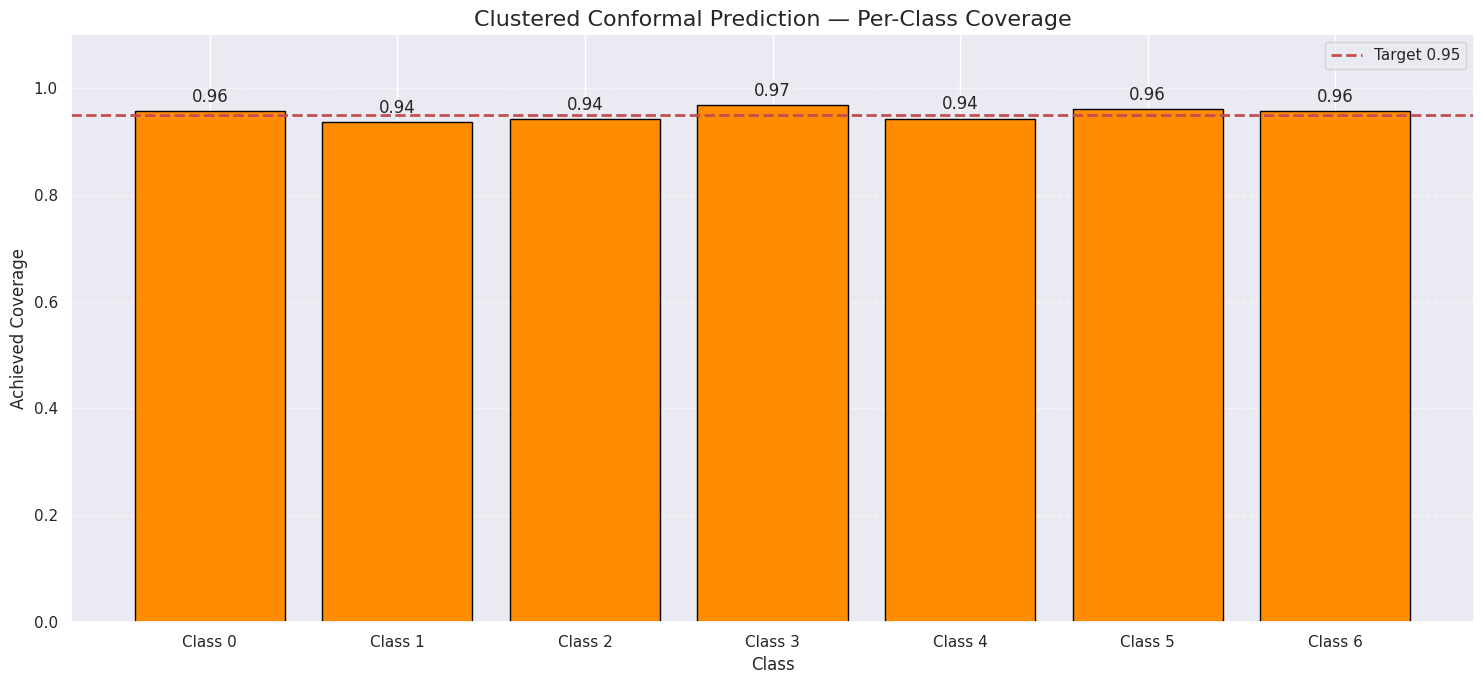

In [ ]:
# -------------------------------------------------------
# 🧠 CLUSTERED CONFORMAL PREDICTION (ClCP) — Compute + Excel Report
# -------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import tensorflow as tf
import time, os, io, openpyxl
from openpyxl.drawing.image import Image as OpenPyXLImage


def clustered_conformal_prediction_keras(
    model, feature_extractor, x_test, y_test,
    alpha=0.05, batch_size=64, n_clusters=4):

    """
    Performs Clustered Conformal Prediction (ClCP) uncertainty analysis for a Keras model.
    Returns cluster assignments and q_hats_per_cluster for visualization.
    """

    print("\n=== Clustered Conformal Prediction (ClCP) ===")

    # 1️⃣ Split test data → calibration + evaluation sets
    x_calib, x_test_new, y_calib, y_test_new = train_test_split(
        np.array(x_test), np.array(y_test),
        test_size=0.5, stratify=y_test, random_state=42
    )
    y_calib, y_test_new = y_calib.reshape(-1), y_test_new.reshape(-1)
    print(f"Calibration set: {len(x_calib)} | New test set: {len(x_test_new)}")

    # 2️⃣ Get probabilities + embeddings
    start = time.time()
    calib_probs = model.predict(x_calib, batch_size=batch_size, verbose=1)
    test_probs  = model.predict(x_test_new, batch_size=batch_size, verbose=1)
    calib_embeds = feature_extractor.predict(x_calib, batch_size=batch_size, verbose=1)
    print(f"Feature embedding + softmax generation took {time.time() - start:.2f}s")

    # 3️⃣ Cluster class representations
    num_classes = calib_probs.shape[1]
    calib_embeds_flat = calib_embeds.reshape(calib_embeds.shape[0], -1)
    mean_embeds_per_class = np.array([
        calib_embeds_flat[y_calib == c].mean(axis=0) if np.any(y_calib == c)
        else np.zeros(calib_embeds_flat.shape[1]) for c in range(num_classes)
    ])

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_assignments = kmeans.fit_predict(mean_embeds_per_class)
    print(f"Clustered {num_classes} classes → {n_clusters} clusters.")
    print("Cluster assignments:", cluster_assignments)

    # 4️⃣ Cluster‑wise calibration
    q_hats_per_cluster = np.zeros(n_clusters)
    for k in range(n_clusters):
        cls_in_cluster = np.where(cluster_assignments == k)[0]
        mask = np.isin(y_calib, cls_in_cluster)
        if mask.sum() == 0:
            q_hats_per_cluster[k] = 1.0
            continue
        scores = 1 - calib_probs[mask, y_calib[mask]]
        n = mask.sum()
        q_level = np.ceil((n + 1) * (1 - alpha)) / n
        q_hats_per_cluster[k] = np.quantile(scores, q_level, method="higher")

    q_hats_clustered = q_hats_per_cluster[cluster_assignments]

    # 5️⃣ Prediction sets & evaluation
    prediction_sets = test_probs >= (1 - q_hats_clustered)
    empirical_cov = prediction_sets[np.arange(len(y_test_new)), y_test_new].mean()
    avg_set_size = prediction_sets.sum(axis=1).mean()

    print(f"\n--- Clustered CP Results ---")
    print(f"Target Coverage: {1-alpha:.3f}")
    print(f"Empirical Coverage: {empirical_cov:.3f}")
    print(f"Average Set Size: {avg_set_size:.3f}")

    # 6️⃣ Per‑class coverage plot
    class_labels = [f"Class {i}" for i in range(num_classes)]
    coverages = []
    for c in range(num_classes):
        mask = (y_test_new == c)
        coverages.append(np.mean(prediction_sets[mask, c]) if mask.sum() else np.nan)

    plt.figure(figsize=(15, 7))
    bars = plt.bar(class_labels, coverages, color="darkorange", edgecolor="black")
    for bar in bars:
        val = bar.get_height()
        if not np.isnan(val):
            plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, f"{val:.2f}",
                     ha='center', va='bottom')
    plt.axhline(1-alpha, color='r', linestyle='--', linewidth=2,
                label=f'Target {1-alpha:.2f}')
    plt.title('Clustered Conformal Prediction — Per-Class Coverage', fontsize=16)
    plt.xlabel('Class'); plt.ylabel('Achieved Coverage')
    plt.ylim(0, 1.1); plt.legend(); plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    # 7️⃣ Save plot into Excel workbook
    output_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Global Filter Networks/6 bands/ClassWiseCP/"
    os.makedirs(output_dir, exist_ok=True)
    excel_path = os.path.join(output_dir, "conformal_reports.xlsx")
    sheet_name = "Clustered Coverage"

    try:
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight'); buf.seek(0)
        if os.path.exists(excel_path):
            wb = openpyxl.load_workbook(excel_path)
            if sheet_name in wb.sheetnames:
                del wb[sheet_name]
            sheet = wb.create_sheet(title=sheet_name)
        else:
            wb = openpyxl.Workbook(); sheet = wb.active; sheet.title = sheet_name
        img = OpenPyXLImage(buf)
        sheet.add_image(img, "A1")
        wb.save(excel_path)
        print(f"Saved coverage plot to Excel sheet '{sheet_name}' in\n{excel_path}")
    except Exception as e:
        print(f"⚠️ Excel save failed: {e}")

    plt.show(); plt.close()

    return {
        "coverage": empirical_cov,
        "avg_set_size": avg_set_size,
        "per_class_coverages": np.array(coverages),
        "cluster_assignments": cluster_assignments,
        "q_hats_per_cluster": q_hats_per_cluster
    }


# ✅ Feature extractor (penultimate layer)
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

# ✅ Run Clustered CP
results = clustered_conformal_prediction_keras(
    model, feature_extractor, x_test, y_test,
    alpha=0.05, batch_size=64, n_clusters=4
)

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


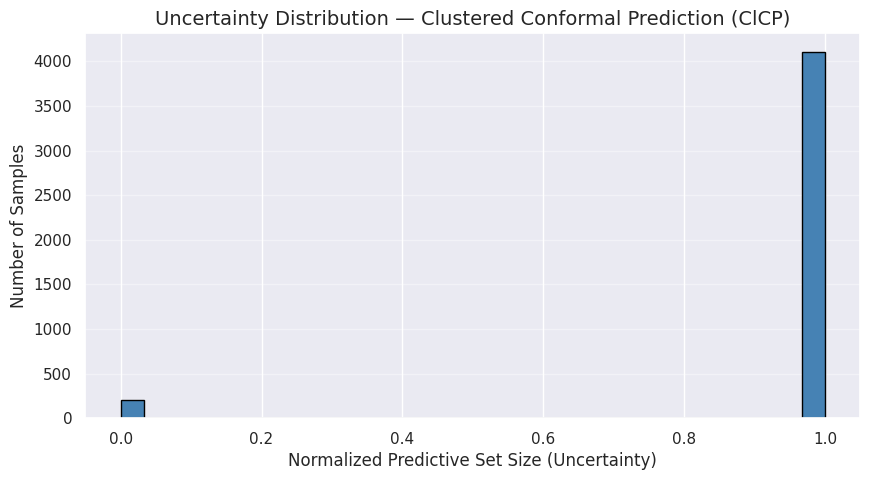

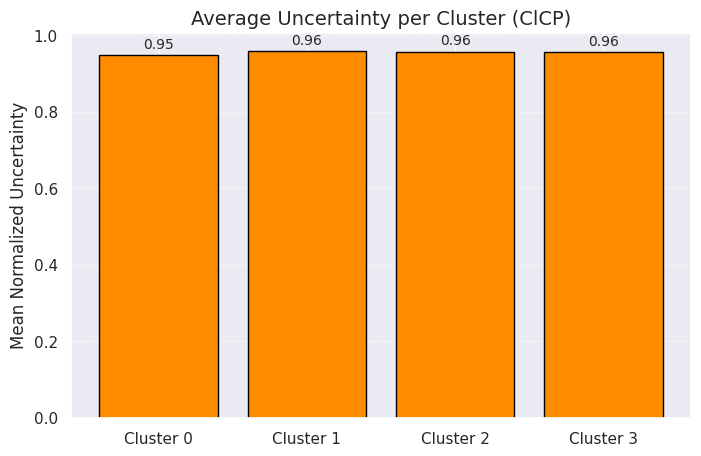

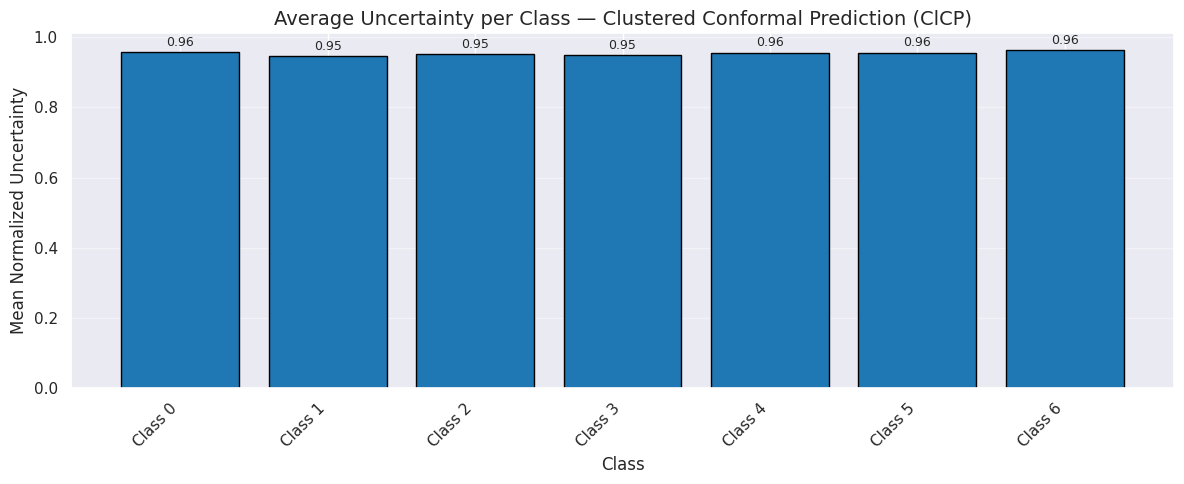

✅ Plots displayed and saved successfully to Excel:
/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Global Filter Networks/6 bands/ClassWiseCP/conformal_reports.xlsx


In [ ]:
# -------------------------------------------------------
# 🟧 UNCERTAINTY VISUALIZATION — Clustered Conformal Prediction (ClCP)
# -------------------------------------------------------

import os
import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl import Workbook, load_workbook
from openpyxl.drawing.image import Image as XLImage

# -------------------------------------------------------
# 🔧 Save Settings
# -------------------------------------------------------
output_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Global Filter Networks/6 bands/ClassWiseCP/"
excel_filename = "conformal_reports.xlsx"
excel_path = os.path.join(output_dir, excel_filename)
os.makedirs(output_dir, exist_ok=True)

# -------------------------------------------------------
# ⚙️ Existing Variables (from your environment)
# -------------------------------------------------------
cluster_assignments = results["cluster_assignments"]          # per-class cluster ID
q_hats_per_cluster = results["q_hats_per_cluster"]
num_classes = len(cluster_assignments)

# Build per-class thresholds
q_per_class = q_hats_per_cluster[cluster_assignments]

# --- Predict on the whole test set ---
prob_pred = model.predict(x_test, batch_size=64, verbose=1)
pred_class = np.argmax(prob_pred, axis=1)

# --- Compute sample-level predictive-set sizes ---
predictive_sets_cl = prob_pred >= (1 - q_per_class)
set_sizes_cl = np.sum(predictive_sets_cl, axis=1)

# --- Normalize predictive-set sizes (0 = certain, 1 = uncertain) ---
norm_uncertainty = (set_sizes_cl - set_sizes_cl.min()) / (set_sizes_cl.max() - set_sizes_cl.min())

# --- Determine cluster ID for each predicted class ---
sample_clusters = np.array(cluster_assignments)[pred_class]

# ===================================================================
# 🎨 1️⃣ Histogram — overall uncertainty distribution
# ===================================================================
fig1 = plt.figure(figsize=(10,5))
plt.hist(norm_uncertainty, bins=30, color='steelblue', edgecolor='black')
plt.xlabel("Normalized Predictive Set Size (Uncertainty)", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.title("Uncertainty Distribution — Clustered Conformal Prediction (ClCP)", fontsize=14)
plt.grid(axis='y', alpha=0.4)
plt.show()

buf1 = io.BytesIO()
fig1.savefig(buf1, format="png", bbox_inches="tight")
buf1.seek(0)
plt.close(fig1)

# ===================================================================
# 🎨 2️⃣ Average Uncertainty per Cluster
# ===================================================================
df = pd.DataFrame({
    "cluster": sample_clusters,
    "uncertainty": norm_uncertainty
})
cluster_mean_unc = df.groupby("cluster")["uncertainty"].mean().sort_index()

fig2 = plt.figure(figsize=(8,5))
bars = plt.bar([f"Cluster {i}" for i in cluster_mean_unc.index],
               cluster_mean_unc.values, color='darkorange', edgecolor='black')
plt.title("Average Uncertainty per Cluster (ClCP)", fontsize=14)
plt.ylabel("Mean Normalized Uncertainty")
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01,
             f"{bar.get_height():.2f}", ha='center', va='bottom', fontsize=10)
plt.show()

buf2 = io.BytesIO()
fig2.savefig(buf2, format="png", bbox_inches="tight")
buf2.seek(0)
plt.close(fig2)

# ===================================================================
# 🎨 3️⃣ Average Uncertainty per Class
# ===================================================================
class_mean_unc = pd.DataFrame({
    "class": np.arange(num_classes),
    "uncertainty": [norm_uncertainty[pred_class == c].mean() for c in range(num_classes)]
}).dropna()

fig3 = plt.figure(figsize=(12,5))
bars = plt.bar(class_mean_unc["class"], class_mean_unc["uncertainty"],
               color='#1f77b4', edgecolor='black')
plt.xticks(class_mean_unc["class"], [f"Class {c}" for c in class_mean_unc["class"]],
           rotation=45, ha='right')
plt.xlabel("Class")
plt.ylabel("Mean Normalized Uncertainty")
plt.title("Average Uncertainty per Class — Clustered Conformal Prediction (ClCP)", fontsize=14)
plt.grid(axis='y', alpha=0.4)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{bar.get_height():.2f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

buf3 = io.BytesIO()
fig3.savefig(buf3, format="png", bbox_inches="tight")
buf3.seek(0)
plt.close(fig3)


# ===================================================================
# 💾 SAVE FIGURES TO EXCEL
# ===================================================================
# Create Excel if missing
if not os.path.exists(excel_path):
    wb = Workbook()
    ws = wb.active
    ws.title = "Info"
    ws["A1"] = "Conformal Prediction Reports"
    ws["A2"] = "Created via Clustered Conformal Prediction script"
    wb.save(excel_path)
    print(f"Created new Excel file at {excel_path}")

# Load workbook
wb = load_workbook(excel_path)
sheet_name = f"ClCP_Run_{len(wb.sheetnames)}"
ws = wb.create_sheet(title=sheet_name)

# Paste images into Excel sheet
img1 = XLImage(buf1)
img1.anchor = "A1"
ws.add_image(img1)

img2 = XLImage(buf2)
img2.anchor = "N1"
ws.add_image(img2)

img3 = XLImage(buf3)
img3.anchor = "A25"
ws.add_image(img3)

# Metadata
ws["A48"] = "Saved by ClCP Visualization Script"
ws["A49"] = "Includes Uncertainty Histogram, Cluster Averages, Class Averages"

# Save workbook
wb.save(excel_path)
print(f"✅ Plots displayed and saved successfully to Excel:\n{excel_path}")

#**RAPS: Calibration & Prediction**


--- Starting RAPS Conformal Prediction ---
Calibration: 2155 | Evaluation: 2155
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Prediction finished in 1.44s
Running RAPS calibration ...
Target Coverage: 0.95 | Empirical Coverage: 0.999 | Avg Set Size: 1.00
Plot saved ⇒ 'RAPS Coverage' sheet in /content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Global Filter Networks/6 bands/ClassWiseCP/conformal_reports.xlsx


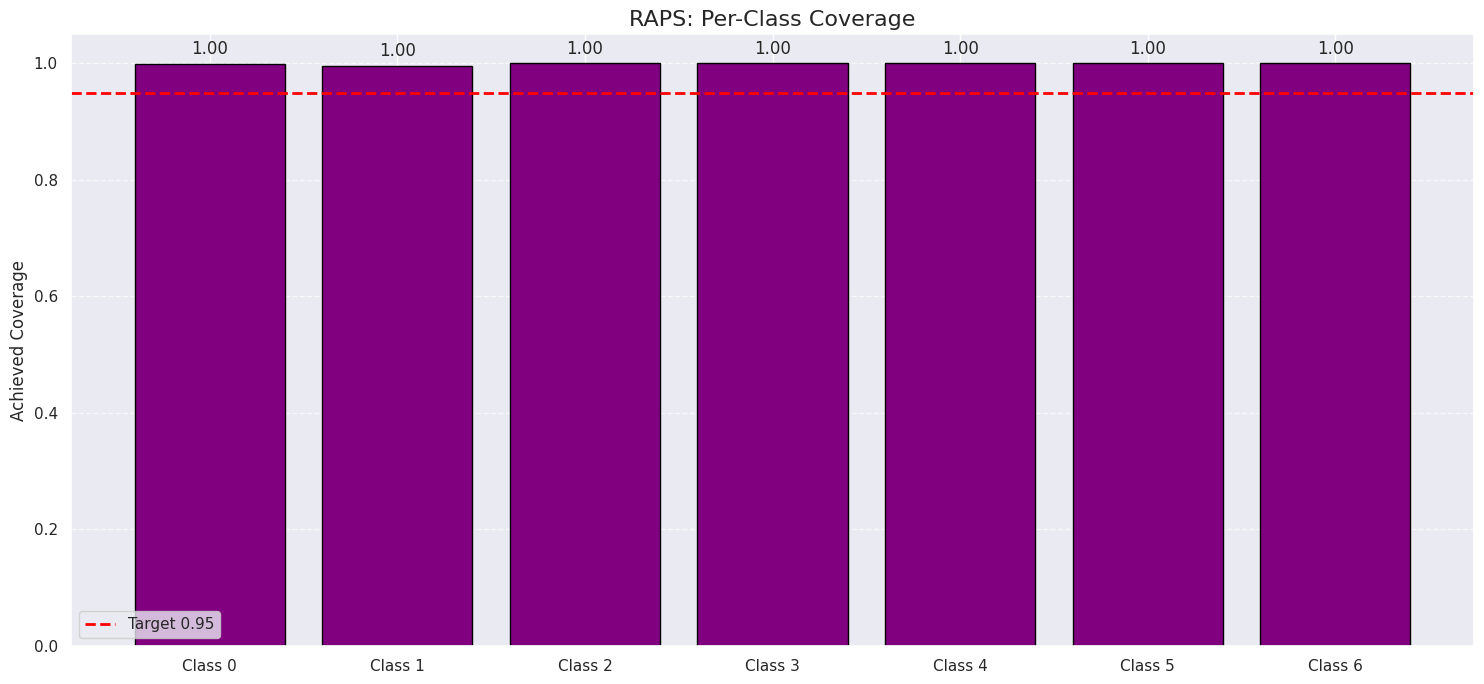

In [ ]:
# -------------------------------------------------------
#  RAPS CONFORMAL PREDICTION (Regularized Adaptive Prediction Sets)
# -------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time, os, io, tensorflow as tf, openpyxl
from openpyxl.drawing.image import Image as OpenPyXLImage

def raps_conformal_prediction_keras(model, x_test, y_test, alpha=0.05, lam=0.01, batch_size=64):
    """
    Regularized Adaptive Prediction Sets (RAPS) for a Keras model.
    Returns prediction_sets_raps and predicted probabilities for uncertainty visualization.
    """
    print("\n--- Starting RAPS Conformal Prediction ---")

    # 1️⃣ Split test set into calibration + evaluation subsets
    x_calib, x_test_new, y_calib, y_test_new = train_test_split(
        np.array(x_test), np.array(y_test),
        test_size=0.5, stratify=y_test, random_state=42
    )
    y_calib, y_test_new = y_calib.reshape(-1), y_test_new.reshape(-1)
    print(f"Calibration: {len(x_calib)} | Evaluation: {len(x_test_new)}")

    # 2️⃣ Model predictions
    start = time.time()
    calib_probs = model.predict(x_calib, batch_size=batch_size, verbose=1)
    test_probs  = model.predict(x_test_new, batch_size=batch_size, verbose=1)
    print(f"Prediction finished in {time.time() - start:.2f}s")

    # 3️⃣ Build RAPS scores
    print("Running RAPS calibration ...")
    n_calib, num_classes = len(y_calib), calib_probs.shape[1]

    calib_probs_sorted = np.sort(calib_probs, axis=1)[:, ::-1]
    calib_ranks = np.argsort(calib_probs, axis=1)[:, ::-1]
    calib_labels_rank = np.array([np.where(calib_ranks[i] == y_calib[i])[0][0] for i in range(n_calib)])
    raps_scores = np.array([
        np.sum(calib_probs_sorted[i, :calib_labels_rank[i]]) + lam * calib_labels_rank[i]
        for i in range(n_calib)
    ])

    # 4️⃣ Quantile threshold
    q_level = np.ceil((n_calib + 1) * (1 - alpha)) / n_calib
    q_hat_raps = np.quantile(raps_scores, q_level, method="higher")

    # 5️⃣ RAPS prediction sets
    test_probs_sorted_indices = np.argsort(test_probs, axis=1)[:, ::-1]
    test_probs_sorted = np.sort(test_probs, axis=1)[:, ::-1]

    prediction_sets_raps = []
    for i in range(len(x_test_new)):
        s, cumulative = [], 0.0
        for k in range(num_classes):
            reg_penalty = lam * k
            if cumulative + reg_penalty <= q_hat_raps:
                s.append(test_probs_sorted_indices[i, k])
                cumulative += test_probs_sorted[i, k]
            else:
                break
        boolean_set = np.zeros(num_classes, dtype=bool)
        if s:
            boolean_set[s] = True
        prediction_sets_raps.append(boolean_set)
    prediction_sets_raps = np.array(prediction_sets_raps)

    # 6️⃣ Metrics
    coverage = prediction_sets_raps[np.arange(len(y_test_new)), y_test_new].mean()
    avg_set_size = prediction_sets_raps.sum(axis=1).mean()
    print(f"Target Coverage: {1-alpha:.2f} | Empirical Coverage: {coverage:.3f} | "
          f"Avg Set Size: {avg_set_size:.2f}")

    # 7️⃣ Per‑class coverage plot
    per_class_coverages = []
    for c in range(num_classes):
        mask = (y_test_new == c)
        if mask.sum() == 0: per_class_coverages.append(np.nan); continue
        per_class_coverages.append(prediction_sets_raps[mask, c].mean())
    per_class_coverages = np.array(per_class_coverages)

    plt.figure(figsize=(15,7))
    bars = plt.bar([f"Class {i}" for i in range(num_classes)],
                   per_class_coverages, color='purple', edgecolor='black')
    for bar in bars:
        yv = bar.get_height()
        if not np.isnan(yv):
            plt.text(bar.get_x()+bar.get_width()/2, yv+0.01, f"{yv:.2f}",
                     ha='center', va='bottom')
    plt.axhline(y=1-alpha, color='red', ls='--', lw=2,
                label=f'Target {1-alpha:.2f}')
    plt.title('RAPS: Per-Class Coverage', fontsize=16)
    plt.ylabel('Achieved Coverage')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.legend()

    # 8️⃣ Save to Excel
    out_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Global Filter Networks/6 bands/ClassWiseCP/"
    os.makedirs(out_dir, exist_ok=True)
    excel_fp = os.path.join(out_dir, "conformal_reports.xlsx")
    sheet = "RAPS Coverage"
    try:
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight'); buf.seek(0)
        if os.path.exists(excel_fp):
            wb = openpyxl.load_workbook(excel_fp)
            if sheet in wb.sheetnames:
                del wb[sheet]
            ws = wb.create_sheet(title=sheet)
        else:
            wb = openpyxl.Workbook(); ws = wb.active; ws.title = sheet
        img = OpenPyXLImage(buf); ws.add_image(img, 'A1')
        wb.save(excel_fp)
        print(f"Plot saved ⇒ '{sheet}' sheet in {excel_fp}")
    except Exception as e:
        print(f"⚠️ Excel save failed: {e}")
    plt.show(); plt.close()

    return {
        "coverage": coverage,
        "avg_set_size": avg_set_size,
        "per_class_coverages": per_class_coverages,
        "prediction_sets_raps": prediction_sets_raps,
        "y_test_new": y_test_new,
        "num_classes": num_classes
    }

# ✅ Run RAPS
results = raps_conformal_prediction_keras(model, x_test, y_test, alpha=0.05, lam=0.01, batch_size=64)